Import external packages.

In [1]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import numpy as np
import time
import tensorflow as tf
import tqdm
import os
from scipy.integrate import solve_ivp, trapz
import findiff
from matplotlib.animation import FFMpegWriter

In [2]:
import sys
sys.path.append('../..')

from systemidentification import twoConductanceEquations

In [3]:
# Configure tensorflow to use only the memory that it needs.
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
%matplotlib notebook

# Define some library functions

In [5]:
def flow_sim(X0,
             flow_time,
             healing_time,
             domain_size,
             domain
             ):
    """
    Return a an integration history object.
    
    Parameters
    ==========
    X0 : the initial condition of the integration
    flow_time : the integration time of the trajectory after healing_time
    healing_time : the healing integration time discarded before flow_time
    domain_size : the number of oscillators in the system
    domain : the applied currents of the oscillators
    
    """
    
    sim = twoConductanceEquations.TwoCondEqnSim(N=domain_size, Iapp=domain)    
    f = twoConductanceEquations.TwoCondEqnSim(N=domain_size, Iapp=domain).diff
    
    # Use Scipy's RK45 integrator for the flow generation.
    history = sim.integrate(
                            X0,
                            t_span=[0, healing_time + flow_time],
                            method='DOP853',
                            dense_output=True,
                            rtol=1e-9,
                            atol=1e-9
                           )
    
    return history
        
def data_generator(initial_conditions,
                   flow_time,
                   healing_time,
                   time_step,
                   domain_size,
                   domain,
                   samples_per_trajectory
                   ):
    """
    Return a set of preflow X data, postflow Y data, and a list of the integration restults for each pair.
    
    Parameters
    ==========
    initial_conditions : an iterator containing the initial conditions of the integration
    flow_time : the integration time of the trajectory after healing_time
    healing_time : the healing integration time discarded before flow_time
    time_step : the time step length used in the flow data generation collection
    domain_size : the number of oscillators in the system
    domain : the applied currents of the oscillators
    samples_per_trajectory : the number of samples collected from each intial condition (trajectory)
    
    """
    results = [flow_sim(X0, flow_time+time_step, healing_time, domain_size, domain) for X0 in tqdm.tqdm_notebook(initial_conditions)]

    X = np.empty((len(results) * samples_per_trajectory, domain_size, 2))
    Y = np.empty((len(results) * samples_per_trajectory, domain_size, 2))
    
    current_sample = 0
    for samp, result in tqdm.tqdm_notebook(enumerate(results), total=len(results)):
        # Pick the starting (X) times evenly over the interval [0, healing_time+flow_time].
        X_times = np.linspace(0, healing_time + flow_time, samples_per_trajectory)
        # Evaluate the end (Y) times at the starting_time + time_step
        Y_times = X_times + time_step
        # Evaluate the states at the selected times.
        states = result.sol(np.column_stack((X_times, Y_times)).ravel())
        for i in range(samples_per_trajectory):
            UV0, UV1 = states[:, 2*i], states[:, 2*i+1]
            X[current_sample, :, :] = UV0.reshape([2, domain_size]).T
            Y[current_sample, :, :] = UV1.reshape([2, domain_size]).T
            current_sample += 1

    return (X, Y, results)

In [6]:
class Normalizer():
    """
    A class for transforming data into mean deviation format.
    """
    
    def __init__(self, mean, std):
        """ Initialize the mean and standard deviation manually. """
        self.normalization_mean = mean
        self.normalization_std = std
    
    @classmethod
    def fromData(cls, data, axis):
        """ Initialize the mean and standard deviation by passing data. """
        normalization_mean = np.mean(data, axis=axis)
        normalization_std = np.std(data, axis=axis)
        return cls(mean=normalization_mean, std=normalization_std)
    
    def normalize(self, data):
        """ Perform the normalization process on the data using the means and stds defined in __init__. """
        return (data - self.normalization_mean) / self.normalization_std
    
    def unnormalize(self, data):
        """ Undo the normalization process on the data using the means and stds defined in __init__. """
        return (data * self.normalization_std) + self.normalization_mean

In [7]:
class Pbar(tf.keras.callbacks.Callback):

    def __init__(self, total):
        super().__init__()
        self.tqdm_notebook = tqdm.tqdm_notebook(total=total)

    def on_epoch_end(self, epoch, logs=None):
        self.tqdm_notebook.update(1)

In [8]:
class LossPerSample(tf.keras.callbacks.Callback):
    
    def __init__(self):
        super().__init__()
        self.batch_losses = []
        
    def on_test_batch_end(self, batch, logs):
        self.batch_losses.append(logs['loss'])

In [9]:
class FiniteDifference1D(tf.keras.layers.Layer):
    """
    Computes 1-dimensional, second order accurate, centered finite differences with convolutions
    for each input channel individually.
    """
    def __init__(self, maximum_derivative, dx, acc, **tf_layer_kwargs):
        super().__init__(**tf_layer_kwargs)
        self.dx = dx
        self.acc = acc
        self.maximum_derivative = maximum_derivative
        self.kernel_size = len(findiff.coefficients(deriv=self.maximum_derivative, acc=self.acc)['center']['coefficients'])
        self.boundary_index = int((self.kernel_size - 1) / 2)
        
    def build(self, input_shape):
        assert input_shape[1] >= self.kernel_size
        fd_kernel = np.zeros((self.kernel_size, 1, self.maximum_derivative + 1))
        for i in range(self.maximum_derivative + 1):
            fd_coeffs = findiff.coefficients(deriv=i, acc=self.acc)['center']['coefficients']
            fd_coeffs_length = len(fd_coeffs)
            pad_width = int((self.kernel_size - fd_coeffs_length) / 2)
            fd_kernel[:, 0, i] = np.pad(fd_coeffs, pad_width, mode='constant', constant_values=0) / self.dx ** i
    
        self.kernel = self.add_weight(name='fd_kernel',
                                      shape=fd_kernel.shape,
                                      initializer=tf.constant_initializer(value=fd_kernel),
                                      dtype=self.dtype,
                                      trainable=False
                                     )
        
    def get_config(self):
        config = super(FiniteDifference1D, self).get_config()
        config.update({'maximum_derivative': self.maximum_derivative,
                       'dx': self.dx,
                       'acc': self.acc}
                     )
        return config
    
    def call(self, inputs):
        finite_differences = []
        for i in range(inputs.shape[-1]):
            finite_differences.append(tf.nn.conv1d(inputs[:, :, i:i+1], self.kernel, stride=1, padding='VALID'))
        return tf.concat(finite_differences, axis=-1)

In [10]:
class WeightedMeanSquaredError(tf.keras.losses.Loss):
    def __init__(self, weights, scale, **kwargs):
        super().__init__(**kwargs)
        self.weights = weights
        self.scale = scale
    
    def get_config(self):
        config = super(WeightedMeanSquaredError, self).get_config()
        config.update({'weights': self.weights,
                       'scale': self.scale}
                     )
        return config
    
    @tf.function
    def call(self, y_true, y_pred):
        return self.scale * tf.math.reduce_mean(self.weights * tf.square(y_true - y_pred))

In [11]:
def pca_filter(data, pca, normalizer, number_of_retained_pca_coordinates):
    norm_data = normalizer.normalize(data)
    pca_data = pca.transform(norm_data)
    pca_data[:, number_of_retained_pca_coordinates:] = 0
    filtered_data = pca.inverse_transform(pca_data)
    return normalizer.unnormalize(filtered_data)

# Define the Notebook Parameters and Load the Data

In [12]:
config = {}

config['GENERAL'] = {}
config['GENERAL']['figure path'] = os.path.join('D:'+os.sep, "Kevrekidis' Lab", 'annForTrajectories', 'examples', 'HH Oscillator Project', 'figures', 'PDE 8 figures')
config['GENERAL']['data path'] = os.path.join('D:'+os.sep, "Kevrekidis' Lab", 'annForTrajectories', 'examples', 'HH Oscillator Project', 'HH Data', 'Data Initialization', 'Initializations.npz')
config['GENERAL']['model load path'] = os.path.join('D:'+os.sep, "Kevrekidis' Lab", 'annForTrajectories', 'examples', 'HH Oscillator Project', 'keras_models', 'fd_models', '8POD_4Layer_HLR')
config['GENERAL']['model save path'] = os.path.join('C:'+os.sep, 'Users', 'Thomas', 'Desktop', 'keras_models', 'fd_models', '8POD_4Layer_HLR')
config['GENERAL']['model checkpoint path'] = os.path.join('C:'+os.sep, 'Users', 'Thomas', 'Desktop', 'keras_models', 'fd_models', '8POD_4Layer', 'checkpoints')
config['GENERAL']['filter comparison'] = False # Run filter comparisons.
config['GENERAL']['flow time comparison'] = False # Run flow time comparisons to debug time derivative accuracy.
config['GENERAL']['model saving'] = False # Whether to save the model, recommended False to avoid overwriting saved models.
config['GENERAL']['model loading'] = True # Whether to load a model.
config['GENERAL']['figure saving'] = False

config['DATA'] = {}
config['DATA']['number of retained pca coordinates'] = 8
config['DATA']['pca perturbation component scales'] = np.ones(config['DATA']['number of retained pca coordinates']) * 0.5
config['DATA']['time step'] = 1e-4
config['DATA']['flow time'] = 10
config['DATA']['healing time'] = 0
config['DATA']['samples per trajectory'] = 500

# Load the initial conditions.
data = np.load(config['GENERAL']['data path'])

config['DATA']['domain'] = data['domain']
config['DATA']['domain size'] = data['domain'].shape[0]
config['DATA']['dx'] = np.diff(data['domain'])[-1]
config['DATA']['adjacency matrix'] = data['adjacency_matrix']
config['DATA']['X0'] = data['X0'].reshape((2, config['DATA']['domain size'])).T
config['DATA']['limit cycle points'] = data['starting_points'][::5, :, :]
config['DATA']['limit cycle times'] = data['starting_times'][::5]
config['DATA']['nsamp'] = config['DATA']['limit cycle points'].shape[0] * config['DATA']['samples per trajectory']

config['MODEL'] = {}
config['MODEL']['learnable kernel'] = False
config['MODEL']['max derivative order'] = 5
config['MODEL']['derivative accuracy order'] = 4
config['MODEL']['boundary index'] = FiniteDifference1D(config['MODEL']['max derivative order'], config['DATA']['dx'], acc=config['MODEL']['derivative accuracy order']).boundary_index
config['MODEL']['hidden layers'] = 4
config['MODEL']['filters'] = 128
config['MODEL']['use batch norm'] = True

config['TRAINING'] = {}
config['TRAINING']['validation split'] = 0.1
config['TRAINING']['batch size'] = int(0.001 * config['DATA']['nsamp'] * (1 - config['TRAINING']['validation split']))
config['TRAINING']['epochs'] = 120
config['TRAINING']['learning rate'] = 4e-3

# LR around 2e-3 works well.
# 1000 batches per epoch
# 120 epochs

# Filtering

<IPython.core.display.Javascript object>


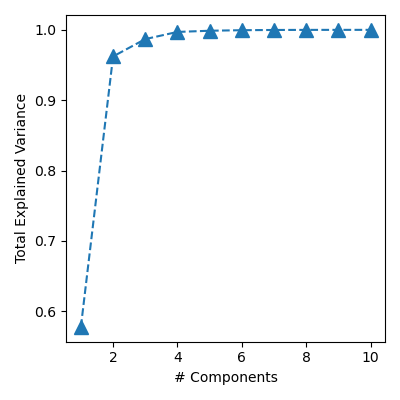

In [13]:
pca = PCA(svd_solver='full')

combined_data = np.transpose(config['DATA']['limit cycle points'], [0, 2, 1]).reshape((-1, 2 * config['DATA']['domain size']))

normalization_mean = np.mean(combined_data, axis=0)
normalization_std = np.std(combined_data, axis=0)
normalizer = Normalizer(mean=normalization_mean, std=normalization_std)

pca.fit(normalizer.normalize(combined_data))

fig, ax = plt.subplots(ncols=1, figsize=(4, 4))
ax.plot(np.arange(1, 11), np.cumsum(pca.explained_variance_ratio_[:10]), marker='^', linestyle='--', markersize=10);

ax.set_xlabel('# Components');
ax.set_ylabel('Total Explained Variance');
fig.tight_layout();

if config['GENERAL']['figure saving']:
    fig.savefig(os.path.join(figure_path, 'explained_variance.png'), dpi=300)

<IPython.core.display.Javascript object>


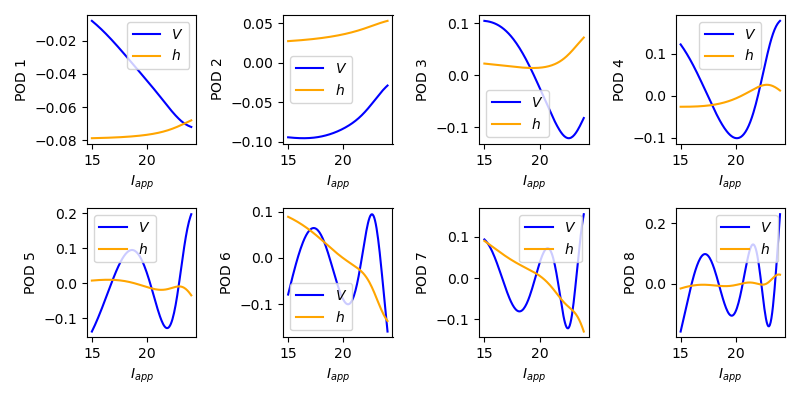

In [14]:
plotted_components = 8
ncols = int(4)
nrows = int(np.ceil(plotted_components / ncols))

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(2 * ncols, 2 * nrows))
component_index = 0
for i in range(nrows):
    for j in range(ncols):
        ax[i, j].plot(config['DATA']['domain'], pca.components_[component_index, :config['DATA']['domain size']], c='blue', label='$V$');
        ax[i, j].plot(config['DATA']['domain'], pca.components_[component_index, config['DATA']['domain size']:], c='orange', label='$h$');
        ax[i, j].set_ylabel('POD ${}$'.format(component_index + 1));
        ax[i, j].set_xlabel('$I_{app}$');
        ax[i, j].legend();
        component_index += 1
fig.tight_layout();

if config['GENERAL']['figure saving']:
    fig.savefig(os.path.join(figure_path, 'POD_modes.png'), dpi=300)

# Filter Comparison
Only run this section to compare the effect of keeping different numbers of PCA modes.

In [15]:
if config['GENERAL']['filter comparison']:
    filter_comparison_sim = twoConductanceEquations.TwoCondEqnSim(N=domain_size, Iapp=domain)
    filter_test = filter_comparison_sim.integrate(X0=X0.T.ravel(),
                                                  t_span=(0, 10),
                                                  dense_output=True,
                                                  rtol=1e-5,
                                                  atol=1e-8
                                                 )

    test_times = np.linspace(0, 10, 1000)
    test_solution = filter_test.sol(test_times)

In [16]:
if config['GENERAL']['filter comparison']:
    fig = plt.figure(figsize=(8, 8))
    ax1 = fig.add_subplot(111, projection='3d')

    xx, yy = np.meshgrid(domain, test_times)

    surf1 = ax1.plot_surface(xx, yy, test_solution[:domain_size, :].T,
                             rcount=200, ccount=200,
                             color='orange',
                             alpha=0.5,
                             )

    surf2 = ax1.plot_surface(xx, yy, pca_filter(test_solution.T, pca, normalizer, 4).T[:domain_size, :].T,
                             rcount=200, ccount=200,
                             color='blue',
                             alpha=0.1,
                            )

    surf3 = ax1.plot_surface(xx, yy, pca_filter(test_solution.T, pca, normalizer, 6).T[:domain_size, :].T,
                             rcount=200, ccount=200,
                             color='green',
                             alpha=0.1,
                            )

    ax1.set_xlabel('$I_{app}$', fontsize=20);
    ax1.set_ylabel('$t$', fontsize=20);
    ax1.set_zlabel('$V$', fontsize=20);

    surf1._facecolors2d = surf1._facecolors3d
    surf1._edgecolors2d = surf1._edgecolors3d

    surf2._facecolors2d = surf2._facecolors3d
    surf2._edgecolors2d = surf2._edgecolors3d

    surf3._facecolors2d = surf3._facecolors3d
    surf3._edgecolors2d = surf3._edgecolors3d

    ax1.legend([surf1, surf2, surf3], ['truth', '4 POD mode filter', '8 POD mode filter']);

    fig.tight_layout();
    fig.subplots_adjust(right=0.9)
    if config['GENERAL']['figure saving']:
        fig.savefig(os.path.join(figure_path, 'V_POD_filter.png'), dpi=300)

In [17]:
if config['GENERAL']['filter comparison']:
    fig = plt.figure(figsize=(8, 8))
    ax1 = fig.add_subplot(111, projection='3d')

    xx, yy = np.meshgrid(domain, test_times)

    surf1 = ax1.plot_surface(xx, yy, test_solution[domain_size:, :].T,
                             rcount=200, ccount=200,
                             color='orange',
                             alpha=0.5,
                             )

    surf2 = ax1.plot_surface(xx, yy, pca_filter(test_solution.T, pca, normalizer, 4).T[domain_size:, :].T,
                             rcount=200, ccount=200,
                             color='blue',
                             alpha=0.1,
                            )

    surf3 = ax1.plot_surface(xx, yy, pca_filter(test_solution.T, pca, normalizer, 8).T[domain_size:, :].T,
                             rcount=200, ccount=200,
                             color='green',
                             alpha=0.1,
                            )

    ax1.set_xlabel('$I_{app}$', fontsize=20);
    ax1.set_ylabel('$t$', fontsize=20);
    ax1.set_zlabel('$h$', fontsize=20);

    surf1._facecolors2d = surf1._facecolors3d
    surf1._edgecolors2d = surf1._edgecolors3d

    surf2._facecolors2d = surf2._facecolors3d
    surf2._edgecolors2d = surf2._edgecolors3d

    surf3._facecolors2d = surf3._facecolors3d
    surf3._edgecolors2d = surf3._edgecolors3d

    ax1.legend([surf1, surf2, surf3], ['truth', '4 POD mode filter', '8 POD mode filter']);

    fig.tight_layout();
    fig.subplots_adjust(right=0.9)
    if config['GENERAL']['figure saving']:
        fig.savefig(os.path.join(figure_path, 'H_POD_filter.png'), dpi=300)

In [18]:
if config['GENERAL']['filter comparison']:
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')

    xx, yy = np.meshgrid(domain, test_times)

    surf1 = ax1.plot_surface(xx, yy, test_solution[:domain_size, :].T - pca_filter(test_solution.T, pca, normalizer, 4).T[:domain_size, :].T,
                             rcount=200, ccount=200,
                             color='red',
                             alpha=0.5,
                             )

    surf2 = ax2.plot_surface(xx, yy, test_solution[:domain_size, :].T - pca_filter(test_solution.T, pca, normalizer, 8).T[:domain_size, :].T,
                             rcount=200, ccount=200,
                             color='red',
                             alpha=0.5,
                             )

    ax1.set_xlabel('$I_{app}$', fontsize=20);
    ax1.set_ylabel('$t$', fontsize=20);
    ax1.set_zlabel('$V$', fontsize=20);

    ax2.set_xlabel('$I_{app}$', fontsize=20);
    ax2.set_ylabel('$t$', fontsize=20);
    ax2.set_zlabel('$V$', fontsize=20);

    surf1._facecolors2d = surf1._facecolors3d
    surf1._edgecolors2d = surf1._edgecolors3d

    surf2._facecolors2d = surf2._facecolors3d
    surf2._edgecolors2d = surf2._edgecolors3d

    ax1.legend([surf1], ['4 pca error']);
    ax2.legend([surf2], ['8 pca error']);

    fig.tight_layout();

In [19]:
if config['GENERAL']['filter comparison']:
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')

    xx, yy = np.meshgrid(domain, test_times)

    surf1 = ax1.plot_surface(xx, yy, test_solution[domain_size:, :].T - pca_filter(test_solution.T, pca, normalizer, 4).T[domain_size:, :].T,
                             rcount=200, ccount=200,
                             color='red',
                             alpha=0.5,
                             )

    surf2 = ax2.plot_surface(xx, yy, test_solution[domain_size:, :].T - pca_filter(test_solution.T, pca, normalizer, 8).T[domain_size:, :].T,
                             rcount=200, ccount=200,
                             color='red',
                             alpha=0.5,
                             )

    ax1.set_xlabel('$I_{app}$', fontsize=20);
    ax1.set_ylabel('$t$', fontsize=20);
    ax1.set_zlabel('$h$', fontsize=20);

    ax2.set_xlabel('$I_{app}$', fontsize=20);
    ax2.set_ylabel('$t$', fontsize=20);
    ax2.set_zlabel('$h$', fontsize=20);

    surf1._facecolors2d = surf1._facecolors3d
    surf1._edgecolors2d = surf1._edgecolors3d

    surf2._facecolors2d = surf2._facecolors3d
    surf2._edgecolors2d = surf2._edgecolors3d

    ax1.legend([surf1], ['4 pca error']);
    ax2.legend([surf2], ['8 pca error']);

    fig.tight_layout();

In [20]:
if config['GENERAL']['filter comparison']:
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(231)
    ax2 = fig.add_subplot(232)
    ax3 = fig.add_subplot(233)
    ax4 = fig.add_subplot(234)
    ax5 = fig.add_subplot(235)
    ax6 = fig.add_subplot(236)
    
    min_V = np.min(test_solution[:domain_size, :])
    max_V = np.max(test_solution[:domain_size, :])
    min_V_error = 0
    V_error_4_modes = np.abs(test_solution[:domain_size, :].T - pca_filter(test_solution.T, pca, normalizer, 4).T[:domain_size, :].T).max()
    V_error_8_modes = np.abs(test_solution[:domain_size, :].T - pca_filter(test_solution.T, pca, normalizer, 8).T[:domain_size, :].T).max()
    max_V_error = np.max((V_error_4_modes, V_error_8_modes))
    
    min_h = np.min(test_solution[domain_size:, :])
    max_h = np.max(test_solution[domain_size:, :])
    min_h_error = 0
    h_error_4_modes = np.abs(test_solution[domain_size:, :].T - pca_filter(test_solution.T, pca, normalizer, 4).T[domain_size:, :].T).max()
    h_error_8_modes = np.abs(test_solution[domain_size:, :].T - pca_filter(test_solution.T, pca, normalizer, 8).T[domain_size:, :].T).max()
    max_h_error = np.max((h_error_4_modes, h_error_8_modes))
    
    im1 = ax1.imshow(test_solution[:domain_size, :].T,
                     vmin=min_V,
                     vmax=max_V,
                     extent=[domain[0], domain[-1], test_times[0], test_times[-1]],
                     aspect='auto',
                     origin='lower')
    div1 = make_axes_locatable(ax1)
    cax1 = div1.append_axes('right', size='10%', pad=0.1)
    fig.colorbar(im1, cax=cax1)
    
    im2 = ax2.imshow(np.abs(test_solution[:domain_size, :].T - pca_filter(test_solution.T, pca, normalizer, 4).T[:domain_size, :].T),
                     vmin=min_V_error,
                     vmax=max_V_error,
                     extent=[domain[0], domain[-1], test_times[0], test_times[-1]],
                     aspect='auto',
                     origin='lower')
    div2 = make_axes_locatable(ax2)
    cax2 = div2.append_axes('right', size='10%', pad=0.1)
    fig.colorbar(im2, cax=cax2)
    
    
    im3 = ax3.imshow(np.abs(test_solution[:domain_size, :].T - pca_filter(test_solution.T, pca, normalizer, 8).T[:domain_size, :].T),
                     vmin=min_V_error,
                     vmax=max_V_error,
                     extent=[domain[0], domain[-1], test_times[0], test_times[-1]],
                     aspect='auto',
                     origin='lower')
    div3 = make_axes_locatable(ax3)
    cax3 = div3.append_axes('right', size='10%', pad=0.1)
    fig.colorbar(im3, cax=cax3)
    
    im4 = ax4.imshow(test_solution[domain_size:, :].T,
                     vmin=min_h,
                     vmax=max_h,
                     extent=[domain[0], domain[-1], test_times[0], test_times[-1]],
                     aspect='auto',
                     origin='lower')
    div4 = make_axes_locatable(ax4)
    cax4 = div4.append_axes('right', size='10%', pad=0.1)
    fig.colorbar(im4, cax=cax4)

    im5 = ax5.imshow(np.abs(test_solution[domain_size:, :].T - pca_filter(test_solution.T, pca, normalizer, 4).T[domain_size:, :].T),
                     vmin=min_h_error,
                     vmax=max_h_error,
                     extent=[domain[0], domain[-1], test_times[0], test_times[-1]],
                     aspect='auto',
                     origin='lower')
    div5 = make_axes_locatable(ax5)
    cax5 = div5.append_axes('right', size='10%', pad=0.1)
    fig.colorbar(im5, cax=cax5)
    
    
    im6 = ax6.imshow(np.abs(test_solution[domain_size:, :].T - pca_filter(test_solution.T, pca, normalizer, 8).T[domain_size:, :].T),
                     vmin=min_h_error,
                     vmax=max_h_error,
                     extent=[domain[0], domain[-1], test_times[0], test_times[-1]],
                     aspect='auto',
                     origin='lower')
    div6 = make_axes_locatable(ax6)
    cax6 = div6.append_axes('right', size='10%', pad=0.1)
    fig.colorbar(im6, cax=cax6)
    
    ax1.set_xlabel('$I_{app}$', fontsize=14);
    ax1.set_ylabel('$t$', fontsize=14);
    ax1.set_title('$V$', fontsize=14)

    ax2.set_xlabel('$I_{app}$', fontsize=14);
    ax2.set_ylabel('$t$', fontsize=14);
    ax2.set_title('Absolute Error $V$, 4 POD Modes', fontsize=14)

    ax3.set_xlabel('$I_{app}$', fontsize=14);
    ax3.set_ylabel('$t$', fontsize=14);
    ax3.set_title('Absolute Error $V$, 8 POD Modes', fontsize=14)
    
    ax4.set_xlabel('$I_{app}$', fontsize=14);
    ax4.set_ylabel('$t$', fontsize=14);
    ax4.set_title('$h$', fontsize=14)
    
    ax5.set_xlabel('$I_{app}$', fontsize=14);
    ax5.set_ylabel('$t$', fontsize=14);
    ax5.set_title('Absolute Error $h$, 4 POD Modes', fontsize=14)

    ax6.set_xlabel('$I_{app}$', fontsize=14);
    ax6.set_ylabel('$t$', fontsize=14);
    ax6.set_title('Absolute Error $h$, 8 POD Modes', fontsize=14)
    
    fig.tight_layout();
    
    if config['GENERAL']['figure saving']:
        fig.savefig(os.path.join(figure_path, 'POD_filter_comparison.png'), dpi=300)

# Perturbations and Flow Generation

In [21]:
# Calculate the mean and std of each coordinate for perturbation scaling.
combined_data = np.transpose(config['DATA']['limit cycle points'], [0, 2, 1]).reshape((-1, 2 * config['DATA']['domain size']))

# Compute the mean and std for each PCA coordinate
combined_mean = np.mean(pca.transform(normalizer.normalize(combined_data)), axis=0)
combined_std = np.std(pca.transform(normalizer.normalize(combined_data)), axis=0)

# Generate some uniform random perturbations over the ranges determined above.
pca_perturbations = np.zeros(combined_data.shape)

for i in range(config['DATA']['number of retained pca coordinates']):
    pca_perturbations[:, i] = np.random.uniform(
                                                low=-config['DATA']['pca perturbation component scales'][i]*combined_std[i],
                                                high=config['DATA']['pca perturbation component scales'][i]*combined_std[i],
                                                size=combined_data.shape[0]
                                               )

# Add the perturbations to the starting points.
pca_starting_points = pca.transform(normalizer.normalize(combined_data))
pca_perturbed_starting_points = pca_starting_points + pca_perturbations
perturbed_starting_points = normalizer.unnormalize(pca.inverse_transform(pca_perturbed_starting_points))
perturbed_starting_points = np.transpose(perturbed_starting_points.reshape((-1, 2, config['DATA']['domain size'])), [0, 2, 1])

<IPython.core.display.Javascript object>


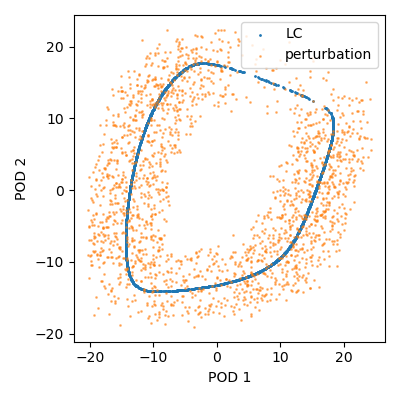

<IPython.core.display.Javascript object>


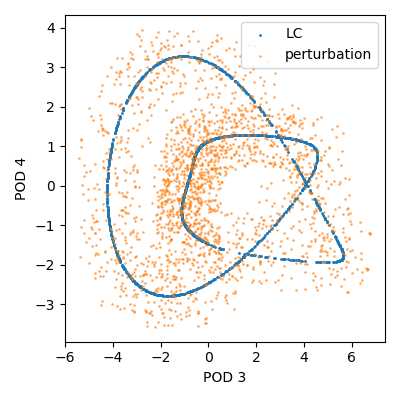

<IPython.core.display.Javascript object>


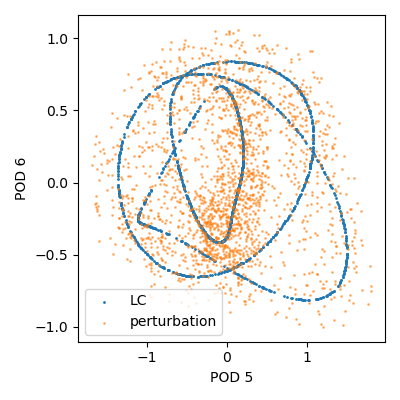

<IPython.core.display.Javascript object>


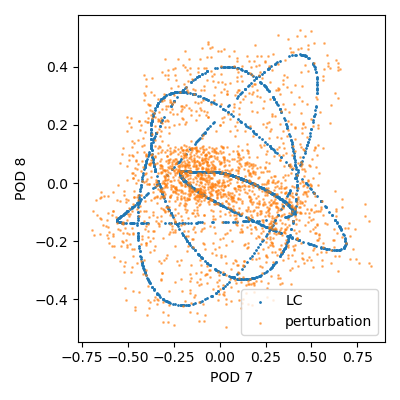

In [22]:
nfigs = int(config['DATA']['number of retained pca coordinates'] / 2)

for i in range(nfigs):
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.scatter(pca.transform(normalizer.normalize(combined_data))[:, 2*i], pca.transform(normalizer.normalize(combined_data))[:, 2*i+1], s=1, label='LC');
    ax.scatter(pca_perturbed_starting_points[:, 2*i], pca_perturbed_starting_points[:, 2*i+1], s=1, alpha=0.5, label='perturbation');
    ax.legend();
    ax.set_xlabel('POD {}'.format(2*i+1));
    ax.set_ylabel('POD {}'.format(2*i+2));
    fig.tight_layout();
    
    if config['GENERAL']['figure saving']:
        fig.savefig(os.path.join(figure_path, 'PDE_perturbations_{}.png'.format(i+1)), dpi=300)

# Flow Time Comparison
Run this section to investigate the effect of different flow times.

In [23]:
if config['GENERAL']['flow time comparison']:
    # Define the data generation parameters.
    time_step = 0.01
    flow_time = 2
    healing_time = 0
    samples_per_trajectory = 200
    nsamp = perturbed_starting_points.shape[0] * samples_per_trajectory

In [24]:
if config['GENERAL']['flow time comparison']:
    flow_tests = []
    time_steps = [1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]

    for time_step in time_steps:

        test = {}

        X_train, Y_train, results = data_generator(np.transpose(perturbed_starting_points, [0, 2, 1]).reshape((perturbed_starting_points.shape[0], 2 * domain_size)),
                                                   flow_time,
                                                   healing_time,
                                                   time_step,
                                                   domain_size,
                                                   domain,
                                                   samples_per_trajectory
                                                  )

        # Calculate the true time derivatives from the ODEs.
        true_derivative = np.stack([sim.diff(None, x.T.ravel()) for x in tqdm.tqdm_notebook(X_train)])
        true_derivative = true_derivative.reshape(-1, 2, domain_size)
        true_derivative = np.transpose(true_derivative, [0, 2, 1])

        # Calculate an approximation of the time derivative.
        approximate_derivative = (Y_train - X_train) / time_step

        test['time_step'] = time_step
        test['X_train'] = X_train
        test['Y_train'] = Y_train
        test['results'] = results
        test['true_derivative'] = true_derivative
        test['approximate_derivative'] = approximate_derivative

        flow_tests.append(test)

In [25]:
if config['GENERAL']['flow time comparison']:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))
    for index, trial in enumerate(flow_tests):
        ax[0].hist((trial['true_derivative']-trial['approximate_derivative']).ravel(), bins=100, alpha=0.5, label='{}'.format(trial['time_step']));
        ax[1].bar(index, np.abs(trial['true_derivative']-trial['approximate_derivative']).mean(), label='{}'.format(trial['time_step']));
        ax[2].bar(index, (trial['true_derivative']-trial['approximate_derivative']).std(), label='{}'.format(trial['time_step']));

    ax[0].set_xlabel('time derivative error (true - fd approx)');
    ax[0].set_ylabel('count');
    ax[0].set_ylim([0, 10000]);
    ax[0].legend();

    ax[1].set_ylabel('mean absolute error');
    ax[1].set_yscale('log');
    ax[1].legend();

    ax[2].set_ylabel('error std');
    ax[2].set_yscale('log');
    ax[2].legend();

    fig.tight_layout();

# Training Data Generation

In [26]:
X_train, Y_train, results = data_generator(np.transpose(perturbed_starting_points, [0, 2, 1]).reshape((perturbed_starting_points.shape[0], 2 * config['DATA']['domain size'])),
                                           config['DATA']['flow time'],
                                           config['DATA']['healing time'],
                                           config['DATA']['time step'],
                                           config['DATA']['domain size'],
                                           config['DATA']['domain'],
                                           config['DATA']['samples per trajectory']
                                          )

C:\Users\Thomas\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:57: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


C:\Users\Thomas\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:63: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [27]:
# Filter the training data to the retained PCA components .
X_train = np.transpose(X_train, [0, 2, 1]).reshape((config['DATA']['nsamp'], 2*config['DATA']['domain size']))
X_train = pca_filter(X_train, pca, normalizer, config['DATA']['number of retained pca coordinates'])
X_train = np.transpose(X_train.reshape((config['DATA']['nsamp'], 2, config['DATA']['domain size'])), [0, 2, 1])

Y_train = np.transpose(Y_train, [0, 2, 1]).reshape((config['DATA']['nsamp'], 2*config['DATA']['domain size']))
Y_train = pca_filter(Y_train, pca, normalizer, config['DATA']['number of retained pca coordinates'])
Y_train = np.transpose(Y_train.reshape((config['DATA']['nsamp'], 2, config['DATA']['domain size'])), [0, 2, 1])

In [28]:
# Compute PCA coordinates for the training data.
pca_X_train = np.empty((X_train.shape[0], config['DATA']['number of retained pca coordinates']))
pca_X_train[:, :] = pca.transform(normalizer.normalize(np.transpose(X_train, [0, 2, 1]).reshape((config['DATA']['nsamp'], 2*config['DATA']['domain size']))))[:, :config['DATA']['number of retained pca coordinates']]

pca_Y_train = np.empty((Y_train.shape[0], config['DATA']['number of retained pca coordinates']))
pca_Y_train[:, :] = pca.transform(normalizer.normalize(np.transpose(Y_train, [0, 2, 1]).reshape((config['DATA']['nsamp'], 2*config['DATA']['domain size']))))[:, :config['DATA']['number of retained pca coordinates']]

<IPython.core.display.Javascript object>


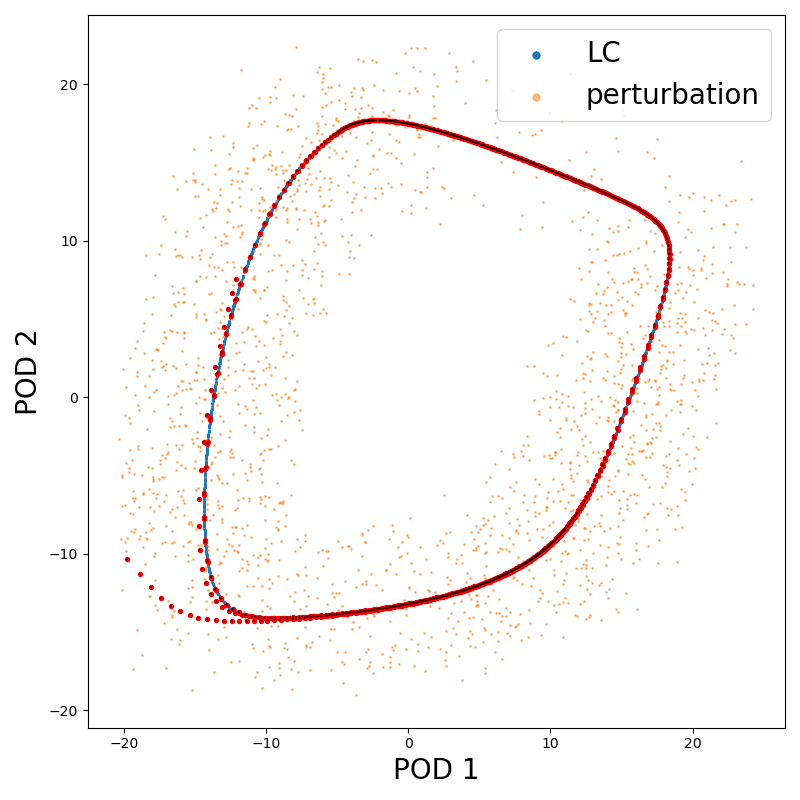

<IPython.core.display.Javascript object>


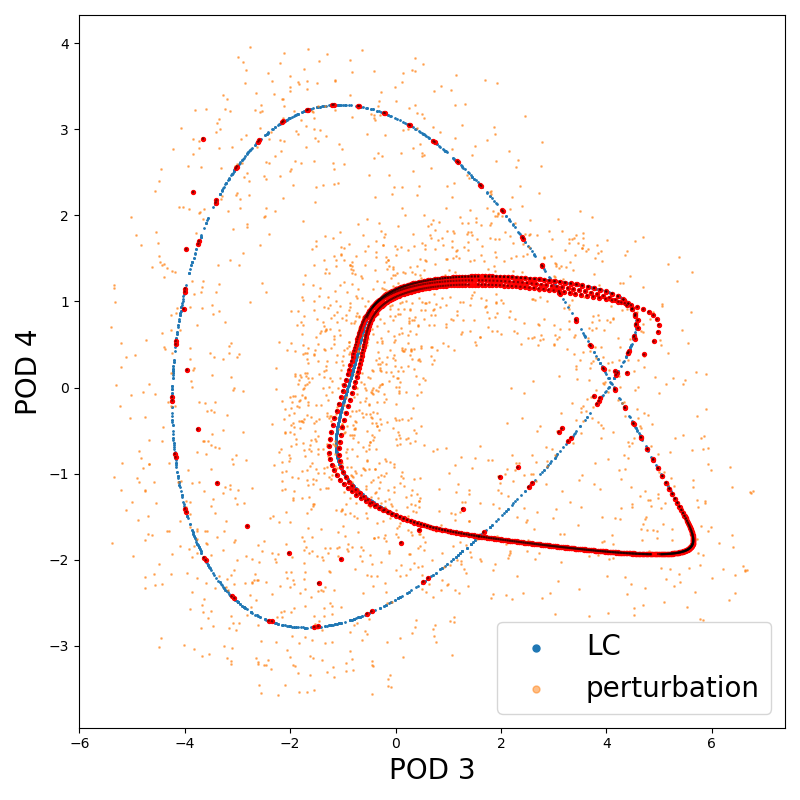

<IPython.core.display.Javascript object>


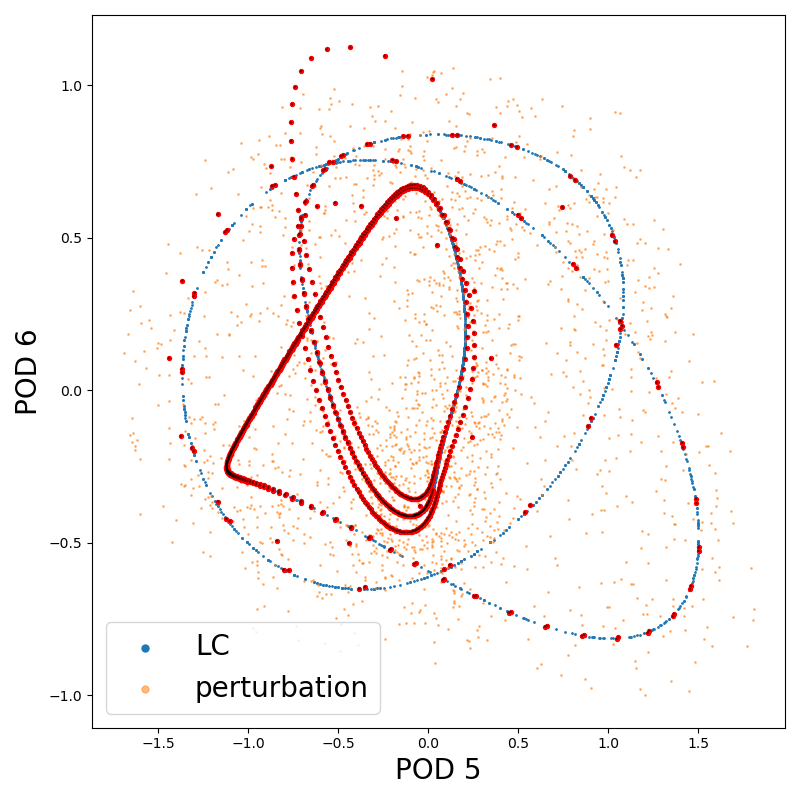

<IPython.core.display.Javascript object>


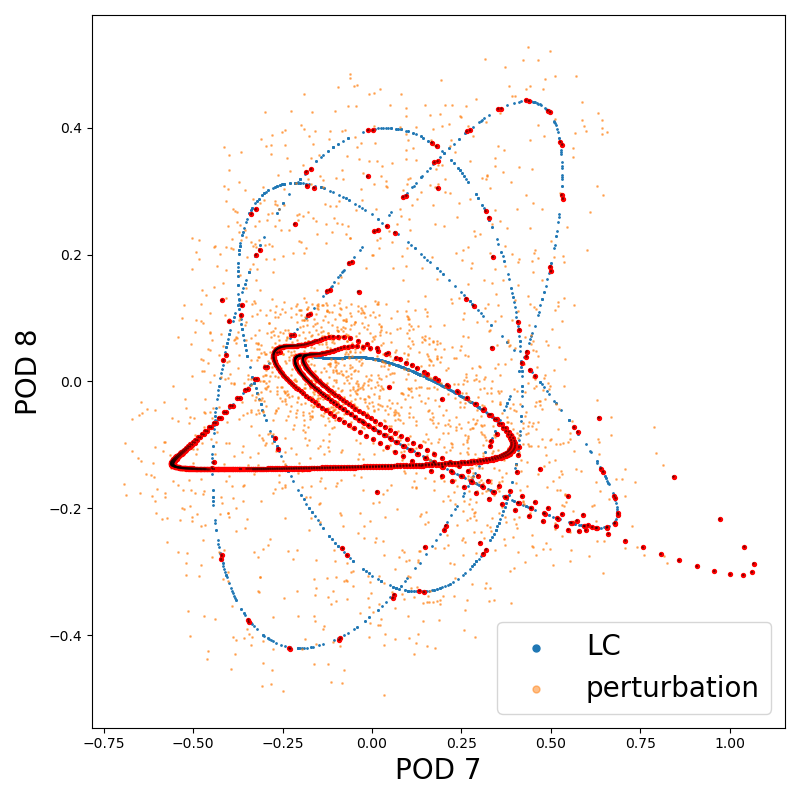

In [29]:
# Check the perturbations of each pca component.
nfigs = int(config['DATA']['number of retained pca coordinates'] / 2)

for i in range(nfigs):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(pca.transform(normalizer.normalize(combined_data))[:, 2*i], pca.transform(normalizer.normalize(combined_data))[:, 2*i+1], s=1, label='LC');
    ax.scatter(pca_perturbed_starting_points[:, 2*i], pca_perturbed_starting_points[:, 2*i+1], s=1, alpha=0.5, label='perturbation');
    for j in range(1000):
        ax.plot(np.array((pca_X_train[j, 2*i], pca_Y_train[j, 2*i])),
                np.array((pca_X_train[j, 2*i+1], pca_Y_train[j, 2*i+1])),
                c='black', alpha=0.5);
        ax.scatter(pca_Y_train[j, 2*i], pca_Y_train[j, 2*i+1], c='red', s=8);
        if config['DATA']['healing time'] > 0:
            ax.plot(pca.transform(normalizer.normalize(results[int(np.floor(j/samples_per_trajectory))].sol(np.linspace(0, healing_time)).T))[:, 2*i],
                    pca.transform(normalizer.normalize(results[int(np.floor(j/samples_per_trajectory))].sol(np.linspace(0, healing_time)).T))[:, 2*i+1],
                    c='teal');
        
    ax.legend(markerscale=5, fontsize=20);
    ax.set_xlabel('POD {}'.format(2*i+1), fontsize=20);
    ax.set_ylabel('POD {}'.format(2*i+2), fontsize=20);

    fig.tight_layout();
    
    if config['GENERAL']['figure saving']:
        fig.savefig(os.path.join(figure_path, 'PDE_trajectories_{}.png'.format(i+1)), dpi=300)

<IPython.core.display.Javascript object>


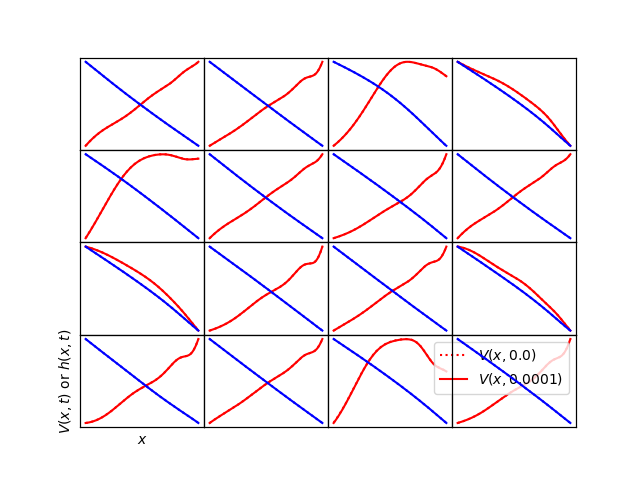

<IPython.core.display.Javascript object>


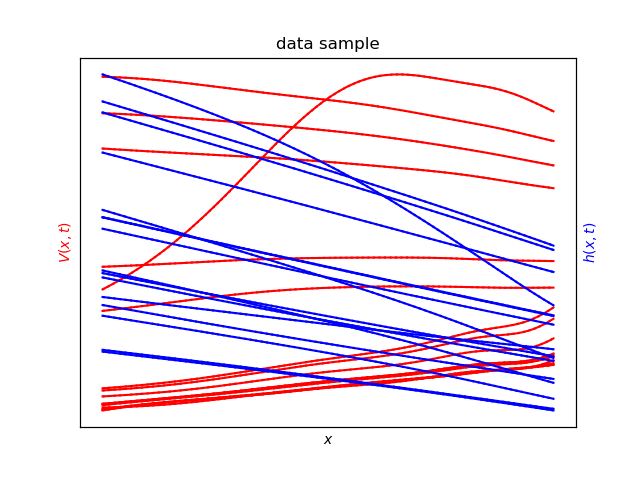

C:\Users\Thomas\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [30]:
fig, axes = plt.subplots(nrows=4, ncols=4)

fullfig, fullax = plt.subplots()
fullbx = fullax.twinx()

order = np.random.permutation(len(X_train))

for iax, ax in enumerate(tqdm.tqdm_notebook(axes.ravel())):
    bx = ax.twinx()
    
    ipick = order[iax]
    
    initial_conditions = X_train[ipick]
    ufinal = Y_train[ipick]
    
    for i in range(2):
        a = [ax, bx][i]
        var = ['V', 'h'][i]
        color = ['red', 'blue'][i]
        a.plot(
            config['DATA']['domain'], initial_conditions[:, i], 
            label='$%s(x, %.1f)$' % (var, 0),
            color=color, linestyle=':'
        )
        a.plot(
            config['DATA']['domain'], ufinal[:, i], 
            label='$%s(x, %s)$' % (var, config['DATA']['time step']),
            color=color, linestyle='-',
        )
    
        fulla = [fullax, fullbx][i]
        fulla.plot(config['DATA']['domain'], initial_conditions[:, i], color=color, linestyle=':')
        fulla.plot(config['DATA']['domain'], ufinal[:, i], color=color, linestyle='-')
        
    for a in [ax, bx, fullax, fullbx]:
        a.set_xticks([])
        a.set_yticks([])
    
    #fullax.plot(initial_conditions, ufinal, color='black', alpha=.5, linestyle='-')
    
ax.legend()

fig.subplots_adjust(wspace=0, hspace=0)

for ax in [axes[-1][0], fullax, fullbx]:
    ax.set_xlabel('$x$')
    if ax != fullax and ax != fullbx:
        ax.set_ylabel('$V(x, t)$ or $h(x, t)$')
    else:
        if ax == fullax:
            label = '$V(x, t)$'
            color = 'red'
        else:
            label = '$h(x, t)$'
            color = 'blue'
        ax.set_ylabel(label, color=color)
    
fullax.set_title('data sample');

# Make a PDE Net

In [31]:
# Instantiate the loss function.
# Compute the loss weights.
loss_weights = 1 / np.std(X_train[:, config['MODEL']['boundary index']:-config['MODEL']['boundary index'], :], axis=0)
loss_weights[:, :] = np.mean(loss_weights, axis=0)
weighted_mse_loss = WeightedMeanSquaredError(loss_weights, 1/config['DATA']['time step'])

In [32]:
def build_model(config, loss_function):

    # Define the inputs.
    states = tf.keras.Input(shape=(config['DATA']['domain size'], 2), name='u')
    
    # Set up the layers.
    layers = []
    
    if config['MODEL']['learnable kernel']:
        feature_layer = tf.keras.layers.Conv1D(filters=2*(config['MODEL']['max derivative order']+1),
                                               kernel_size=(2*config['MODEL']['boundary index'])+1,
                                               use_bias=False,
                                               name='learnable_kernel')
    else:
        feature_layer = FiniteDifference1D(config['MODEL']['max derivative order'],
                                           config['DATA']['dx'],
                                           acc=config['MODEL']['derivative accuracy order'],
                                           name='fd_layer',
                                           dtype=tf.float64)
    
    for i in range(config['MODEL']['hidden layers']):
        layers.append(tf.keras.layers.Conv1D(filters=config['MODEL']['filters'], kernel_size=1, name='Conv1D_{}'.format(i)))
        if config['MODEL']['use batch norm']:
            layers.append(tf.keras.layers.BatchNormalization(name='BN_{}'.format(i)))
        layers.append(tf.keras.layers.Activation(activation=tf.keras.activations.relu, name='Activation_{}'.format(i)))
    
    layers.append(tf.keras.layers.Conv1D(filters=2, kernel_size=1, name='du_dt'))

    # Apply the layers.
    layer_reference = feature_layer(states)

    for layer in layers:
        layer_reference = layer(layer_reference)
    time_derivatives = layer_reference
    
    # Define the derivative model.
    derivative_model = tf.keras.Model(inputs=states, outputs=time_derivatives, name='derivative_model')
    
    # Flow model integration.
    du_dt = derivative_model(states)
    dt = tf.constant(config['DATA']['time step'], dtype='float32', name='time_step')
    euler_step = tf.math.multiply(du_dt, dt)
    new_states = tf.keras.layers.Add()([states[:, config['MODEL']['boundary index']:-config['MODEL']['boundary index']], euler_step])
    
    # Define the flow model.
    flow_model = tf.keras.Model(inputs=states, outputs=new_states, name='flow_model')
    
    # Compile the flow model.
    flow_model.compile(optimizer=tf.keras.optimizers.Adam(config['TRAINING']['learning rate']), loss=loss_function)

    print('feature layer kernel size: {}'.format(feature_layer.kernel_size))
    
    return (derivative_model, flow_model)

In [33]:
derivative_model, flow_model = build_model(config, weighted_mse_loss)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

feature layer kernel size: 9


In [34]:
# Define the callbacks.
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
                                                          monitor='loss',
                                                          factor=0.5,
                                                          patience=20,
                                                          min_lr=1e-5,
                                                          cooldown=0,
                                                          min_delta=1e-6
                                                         )

# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#                                                                filepath=os.path.join(model_checkpoint_path, 'weights.{epoch:02d}'),
#                                                                save_weights_only=True,
#                                                                monitor='val_loss',
#                                                                mode='min',
#                                                                save_best_only=True)

In [35]:
flow_model.summary()

Model: "flow_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
u (InputLayer)                  [(None, 128, 2)]     0                                            
__________________________________________________________________________________________________
derivative_model (Functional)   (None, 120, 2)       53560       u[0][0]                          
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, 120, 2)]     0           u[0][0]                          
__________________________________________________________________________________________________
tf_op_layer_Mul (TensorFlowOpLa [(None, 120, 2)]     0           derivative_model[0][0]           
_________________________________________________________________________________________

In [36]:
derivative_model.summary()

Model: "derivative_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
u (InputLayer)               [(None, 128, 2)]          0         
_________________________________________________________________
fd_layer (FiniteDifference1D (None, 120, 12)           54        
_________________________________________________________________
Conv1D_0 (Conv1D)            (None, 120, 128)          1664      
_________________________________________________________________
BN_0 (BatchNormalization)    (None, 120, 128)          512       
_________________________________________________________________
Activation_0 (Activation)    (None, 120, 128)          0         
_________________________________________________________________
Conv1D_1 (Conv1D)            (None, 120, 128)          16512     
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 120, 128)     

In [37]:
import gc
gc.collect()

302

# Train

In [38]:
if config['GENERAL']['model loading']:
    # Load a previously trained model.
    custom_objects = {'WeightedMeanSquaredError': WeightedMeanSquaredError, 'FiniteDifference1D': FiniteDifference1D}
    with tf.keras.utils.custom_object_scope(custom_objects):
        derivative_model = tf.keras.models.load_model(os.path.join(config['GENERAL']['model load path'], 'derivative_model'))
        flow_model = tf.keras.models.load_model(os.path.join(config['GENERAL']['model load path'], 'flow_model'))
else:
    # Train the model
    with tf.device('/gpu:0'):
        history = flow_model.fit(x={'u': X_train},
                                 y=Y_train[:, config['MODEL']['boundary index']:-config['MODEL']['boundary index'], :],
                                 validation_split=config['TRAINING']['validation split'],
                                 epochs=config['TRAINING']['epochs'],
                                 verbose=0,
                                 batch_size=config['TRAINING']['batch size'],
                                 callbacks=[Pbar(config['TRAINING']['epochs']), reduce_lr_callback]
                                )

In [39]:
if not config['GENERAL']['model loading']:
    fig, ax = plt.subplots()

    line1 = ax.plot(history.epoch, history.history['loss'], c='teal', alpha=0.25, label='training');
    if config['TRAINING']['validation split'] > 0:
        line2 = ax.plot(history.epoch, history.history['val_loss'], c='violet', label='validate');

    ax.set_xlabel('epoch');
    ax.set_ylabel('loss');
    ax.set_yscale('log');

    bx = ax.twinx()
    line3 = bx.plot(history.epoch, history.history['lr'], label='learning rate');

    bx.set_ylabel('learning rate');
    bx.set_yscale('log');

    lines = line1 + line2 + line3
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc=3);

    fig.tight_layout();
    
    if config['GENERAL']['figure saving']:
        fig.savefig(os.path.join(figure_path, 'train_and_validation_loss.png'), dpi=300)

In [40]:
if config['GENERAL']['model saving']:
    # Save the trained models.
    derivative_model.save(os.path.join(model_save_path, 'derivative_model'))
    flow_model.save(os.path.join(model_save_path, 'flow_model'))

In [41]:
gc.collect()

131

# Show that the PDE was trained

In [42]:
sim = twoConductanceEquations.TwoCondEqnSim(N=config['DATA']['domain size'],
                                            Iapp=config['DATA']['domain'],
                                            A=config['DATA']['adjacency matrix'])

# Calculate the true time derivatives from the ODEs.
fxn_actual = np.stack([sim.diff(None, x.T.ravel()) for x in tqdm.tqdm_notebook(X_train)])
fxn_actual = fxn_actual.reshape(-1, 2, config['DATA']['domain size'])
fxn_actual = np.copy(fxn_actual[:, :, config['MODEL']['boundary index']:-config['MODEL']['boundary index']])
fxn_actual = np.transpose(fxn_actual, [0, 2, 1])

C:\Users\Thomas\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [43]:
# Calculate the neural network approximation of the time derivatives.
fxn = derivative_model.predict({'u': X_train},
                               batch_size=config['TRAINING']['batch size']
                              )

In [44]:
# Find the profiles corresponding to the best and worst trained cases.
loss_cb = LossPerSample()

with tf.device('/gpu:0'):
    test = flow_model.evaluate({'u': X_train},
                               Y_train[:, config['MODEL']['boundary index']:-config['MODEL']['boundary index']],
                               batch_size=config['DATA']['samples per trajectory'],
                               callbacks=[loss_cb]
                              )

losses = np.array(loss_cb.batch_losses)

ibest = np.argmin(losses) * config['DATA']['samples per trajectory']
iworst = np.argmax(losses) * config['DATA']['samples per trajectory']

2000/2000 [==============================] - 11s 5ms/step - loss: 1.1534e-05


In [45]:
# Get the profiles corresponding to the best and worst trained samples.
X0_best = np.copy(X_train[ibest, :, :])
X0_worst = np.copy(X_train[iworst, :, :])

X1_true_best = np.copy(Y_train[ibest, :, :])
X1_true_worst = np.copy(Y_train[iworst, :, :])

In [46]:
# Predict the trained flows for the best and worst losses.
X1_best = np.copy(Y_train[ibest, :, :])
X1_predict_best = flow_model.predict({'u': X0_best[None, :, :]})
X1_best[config['MODEL']['boundary index']:-config['MODEL']['boundary index'], :] = X1_predict_best

X1_worst = np.copy(Y_train[iworst, :, :])
X1_predict_worst = flow_model.predict({'u': X0_worst[None, :, :]})
X1_worst[config['MODEL']['boundary index']:-config['MODEL']['boundary index'], :] = X1_predict_worst

In [47]:
def flow_plotting(fig, axis, case):

    if case == 'worst':
        X0 = X0_worst
        X1 = X1_worst
        X1_true = X1_true_worst
        itest = iworst

    elif case == 'best':
        X0 = X0_best
        X1 = X1_best
        X1_true = X1_true_best
        itest = ibest

    ispecs = [0, 1]

    for ispec in ispecs:
        c = 'rb'[ispec]
        s = 'Vh'[ispec]

        # Plot flows
        axis[0, ispec].plot(config['DATA']['domain'], X0[:, ispec], '%s:' % c, label='$%s(t=%.1f)$' % (s, 0,))
        axis[0, ispec].plot(config['DATA']['domain'], X1_true[:, ispec], '%s-' % c, label='$%s(t=%s)$' % (s, config['DATA']['time step']), linewidth=0.5)
        axis[0, ispec].plot(config['DATA']['domain'], X1[:, ispec], '%s-' % c, label=r'$\hat %s(t=%s)$' % (s, config['DATA']['time step']), linewidth=5, alpha=0.5)
        axis[0, ispec].grid(False)

        # Plot flow errors
        axis[1, ispec].plot(config['DATA']['domain'], X1_true[:, ispec] - X1[:, ispec], '%s-' % c, label='$%s(t=%s)$ - $\hat %s(t=%s)$' % (s, config['DATA']['time step'], s, config['DATA']['time step']), linewidth=0.5)
        axis[1, ispec].grid(False)

    for j in range(2):
        for i in ispecs:
            if j==1:
                ax[j, i].set_ylabel(r'$\epsilon_%s(x, t)$' % ('Vh'[ispecs[i]],));
                ax[j, i].set_xlabel('$I_{app}$');
            ax[j, i].legend(loc='upper left');

    fig.suptitle('{0} Case, Loss = {1:.2e}'.format(case.capitalize(), losses[int(itest/config['DATA']['samples per trajectory'])]))
    fig.tight_layout();
    fig.subplots_adjust(top=0.9)

<IPython.core.display.Javascript object>


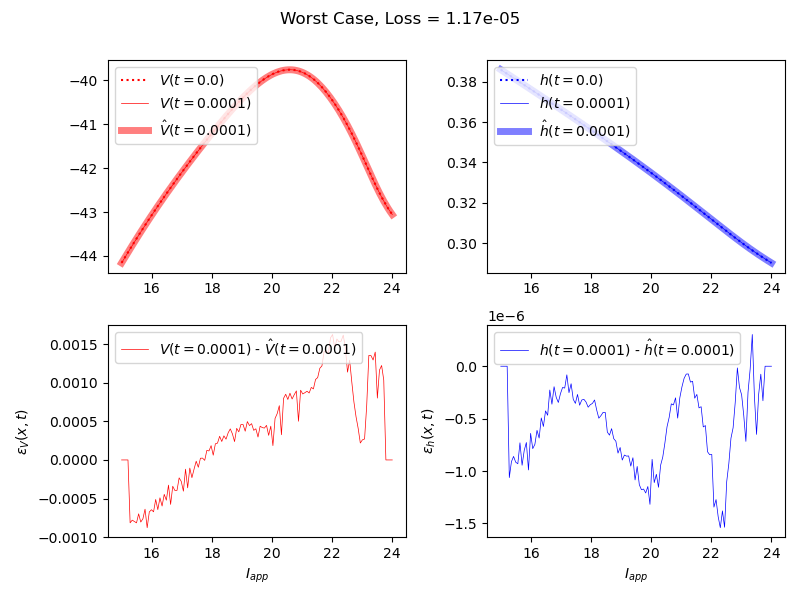

<IPython.core.display.Javascript object>


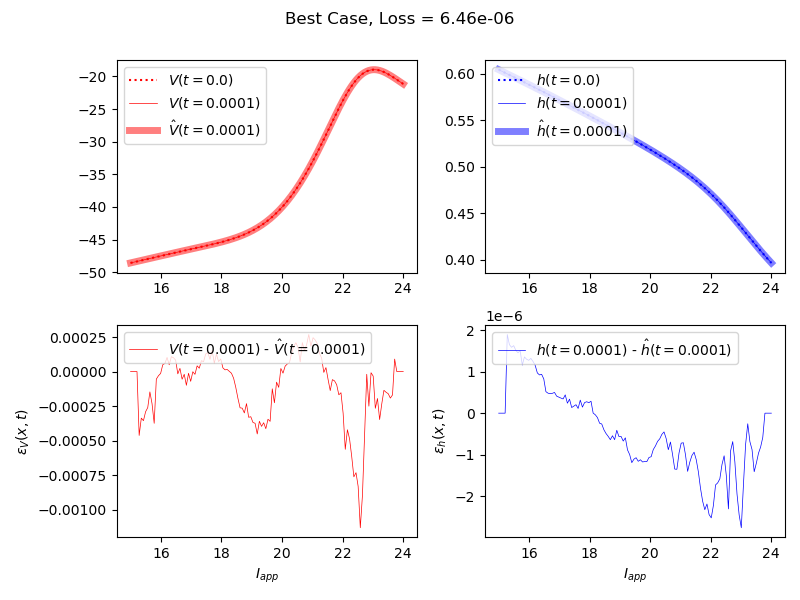

In [48]:
# Plot the trained flows for the best and worst losses.
for test_case in ['worst', 'best']:
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))

    flow_plotting(fig, ax, test_case)

<IPython.core.display.Javascript object>


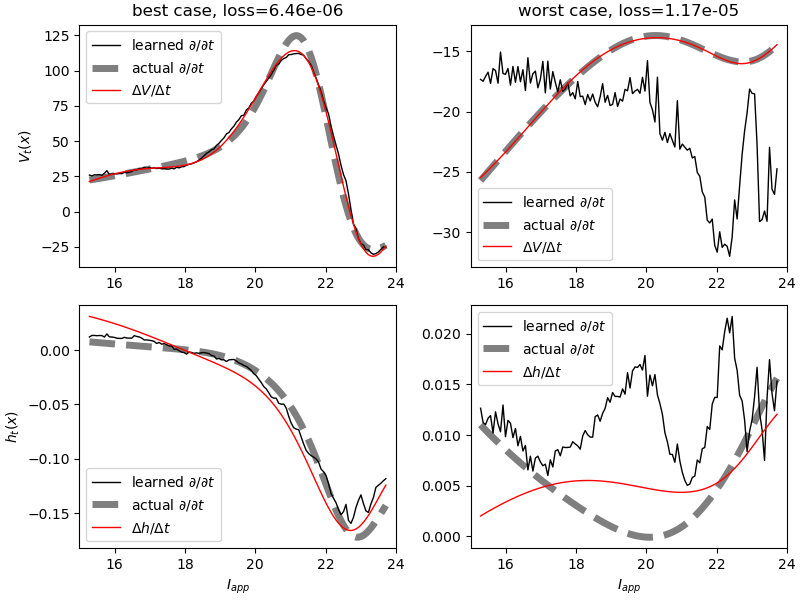

In [49]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 6), constrained_layout=True)

for icase in range(2):

    if icase == 0:
        itest = ibest
    else:
        itest = iworst

    for ispec in range(2):
        s = 'Vh'[ispec]

        ax[ispec, icase].plot(config['DATA']['domain'][config['MODEL']['boundary index']:-config['MODEL']['boundary index']], fxn[itest, :, ispec], label=r'learned $\partial/\partial t$',
                              color='black', linestyle='-', linewidth=1)
        ax[ispec, icase].plot(config['DATA']['domain'][config['MODEL']['boundary index']:-config['MODEL']['boundary index']], fxn_actual[itest, :, ispec], label=r'actual $\partial/\partial t$',
                              color='black', linestyle='--', linewidth=5, alpha=0.5)
        ax[ispec, icase].plot(config['DATA']['domain'][config['MODEL']['boundary index']:-config['MODEL']['boundary index']], ((Y_train[itest, config['MODEL']['boundary index']:-config['MODEL']['boundary index'], ispec] - X_train[itest, config['MODEL']['boundary index']:-config['MODEL']['boundary index'], ispec]) / config['DATA']['time step']),
                              label='$\Delta {0}/ \Delta t$'.format(s), color='red', linestyle='-', linewidth=1, alpha=1)

        ax[0, 0].set_title('best case, loss={:.2e}'.format(losses[int(ibest/config['DATA']['samples per trajectory'])]));
        ax[0, 1].set_title('worst case, loss={:.2e}'.format(losses[int(iworst/config['DATA']['samples per trajectory'])]));

        if ispec:
            ax[ispec, icase].set_xlabel('$I_{app}$')
        if not icase:
            ax[ispec, icase].set_ylabel('$%s_t(x)$' % s)

        ax[ispec, icase].grid(False)
        ax[ispec, icase].set_xlim(config['DATA']['domain'].min(), config['DATA']['domain'].max())
        ax[ispec, icase].legend();
        
if config['GENERAL']['figure saving']:
    fig.savefig(os.path.join(config['GENERAL']['figure path'], 'PDE_time_derivatives.png'), dpi=300)

In [50]:
gc.collect()

11293

# Test the learned PDE

In [51]:
def rhs_generator(pca,
                  normalizer,
                  number_of_retained_pca_coordinates, 
                  boundary_index,
                  domain_size,
                  derivative_model,
                  boundary_condition_sim
                 ):
    
    def f(unused_t, U):
        """ Use the learned PDE. U is ordered V then h. """
        # Evaluate the true equations (ODEs) to get the true profile on the boundary.
        U_feed = boundary_condition_sim.history.sol(unused_t).reshape((2, domain_size)).T

        # Overwrite the interior with U, while leaving the boundaries as the true solution.
        U_feed[boundary_index:-boundary_index, :] = U.reshape((2, domain_size-(boundary_index*2))).T

        # Filter U_feed.
        U_feed = pca_filter(U_feed.T.ravel()[None, :], pca, normalizer, number_of_retained_pca_coordinates)
        U_feed = U_feed.reshape((2, domain_size)).T

        # Add the batch dimension for prediction.
        U_feed = U_feed[None, :, :]
    
        # Predict the derivative.
        dU_dt = derivative_model.predict_on_batch({'u': U_feed})

        # Transpose the shape to (#species, domain_size) before raveling to get Vs followed by hs.
        dU_dt = np.transpose(dU_dt, [0, 2, 1]).ravel()
        
        integration_progress_bar.last_print_n = integration_progress_bar.n = 0
        integration_progress_bar.last_print_t = integration_progress_bar.start_t = integration_progress_bar._time()
        integration_progress_bar.update(unused_t)
        integration_progress_bar.refresh()
        return dU_dt

    return f

# Test the rhs definition.
t_out = np.arange(0, 0.2, 0.05)

boundary_condition_sim = twoConductanceEquations.TwoCondEqnSim(N=config['DATA']['domain size'], Iapp=config['DATA']['domain'])
boundary_condition_sim.integrate(X0=config['DATA']['X0'].T.ravel(),
                                 t_span=(t_out[0], t_out[-1]),
                                 dense_output=True,
                                 rtol=1e-5,
                                 atol=1e-8
                                )

f = rhs_generator(pca,
                  normalizer,
                  config['DATA']['number of retained pca coordinates'],
                  config['MODEL']['boundary index'],
                  config['DATA']['domain size'],
                  derivative_model,
                  boundary_condition_sim)

integration_progress_bar = tqdm.tqdm_notebook(desc='time', total=t_out[-1],
                                              bar_format='{desc}: {percentage:3.0f}%|{bar}| {n:.3f}/{total:.3f} [{elapsed}<{remaining}, ' '{rate_fmt}{postfix}]')
print('ODE output shape is', f(0, config['DATA']['X0'][config['MODEL']['boundary index']:-config['MODEL']['boundary index']].T.ravel()).shape)
integration_progress_bar.close()

C:\Users\Thomas\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:59: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


ODE output shape is (240,)



In [52]:
def rhs_generator_no_filter(pca,
                            normalizer,
                            number_of_retained_pca_coordinates, 
                            boundary_index,
                            domain_size,
                            derivative_model,
                            boundary_condition_sim
                           ):
    
    def f(unused_t, U):
        """ Use the learned PDE. U is ordered V then h. """
        # Evaluate the true equations (ODEs) to get the true profile on the boundary.
        U_feed = boundary_condition_sim.history.sol(unused_t).reshape((2, domain_size)).T

        # Overwrite the interior with U, while leaving the boundaries as the true solution.
        U_feed[boundary_index:-boundary_index, :] = U.reshape((2, domain_size-(boundary_index*2))).T

        # Add the batch dimension for prediction.
        U_feed = U_feed[None, :, :]

        # Predict the derivative.
        dU_dt = derivative_model.predict_on_batch({'u': U_feed})

        # Transpose the shape to (#species, domain_size) before raveling to get Vs followed by hs.
        dU_dt = np.transpose(dU_dt, [0, 2, 1]).ravel()
        
        integration_progress_bar.last_print_n = integration_progress_bar.n = 0
        integration_progress_bar.last_print_t = integration_progress_bar.start_t = integration_progress_bar._time()
        integration_progress_bar.update(unused_t)
        integration_progress_bar.refresh()
        return dU_dt

    return f

# Test the rhs definition.
t_out = np.arange(0, 0.2, 0.05)

boundary_condition_sim = twoConductanceEquations.TwoCondEqnSim(N=config['DATA']['domain size'], Iapp=config['DATA']['domain'])
boundary_condition_sim.integrate(X0=config['DATA']['X0'].T.ravel(),
                                 t_span=(t_out[0], t_out[-1]),
                                 dense_output=True,
                                 rtol=1e-5,
                                 atol=1e-8
                                )

f = rhs_generator(pca,
                  normalizer,
                  config['DATA']['number of retained pca coordinates'],
                  config['MODEL']['boundary index'],
                  config['DATA']['domain size'],
                  derivative_model,
                  boundary_condition_sim)

integration_progress_bar = tqdm.tqdm_notebook(desc='time', total=t_out[-1],
                                              bar_format='{desc}: {percentage:3.0f}%|{bar}| {n:.3f}/{total:.3f} [{elapsed}<{remaining}, ' '{rate_fmt}{postfix}]')
print('ODE output shape is', f(0, config['DATA']['X0'][config['MODEL']['boundary index']:-config['MODEL']['boundary index']].T.ravel()).shape)
integration_progress_bar.close()

C:\Users\Thomas\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:55: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


ODE output shape is (240,)



In [53]:
def Euler_integrator(fun, y0, t0, dt, steps):
    '''
    Integrate ODEs with Euler's method.
    
    Attributes
    ==========
    
    fun : (function) - The time derivative.
    
    y0 : (np.array) - The initial condition.
    
    t0: (np.array) - The initial time.
    
    dt : (np.array) - The time step.
    
    steps : (int) - The number of integration steps.
    '''
    y_solution = []
    t_solution = []
    
    # Set y0 and t0 as the current state and time respectively.
    y_current = y0
    t_current = t0
        
    # Add the initial time and initial condition to the solutions.
    y_solution.append(y_current)
    t_solution.append(t_current)
    
    # Integrate forward in time with Euler's method for number_of_steps.
    for i in tqdm.tqdm_notebook(range(steps)):
        y_next = y_current + (fun(t_current, y_current) * dt)
        t_next = t_current + dt
        
        # Append the new points to the solutions.
        y_solution.append(y_next)
        t_solution.append(t_next)
        
        # Set the next points as the current points.
        y_current = y_next
        t_current = t_next
        
    # Save the integration results as the attributes of a bunch object.
    class Bunch():
        pass
    
    history = Bunch()
    history.y = np.array(y_solution).T
    history.t = np.array(t_solution)
    
    return history

In [54]:
def replace_interior_of_true_solution(learned_solution, true_solution):
    # Replace the interior of the true solution with the neural network approximate solution.
    
    full_sol = np.copy(true_solution.y)
    interior_sol = np.copy(learned_solution.y)
    
    full_sol = full_sol.T.reshape((-1, 2, config['DATA']['domain size']))
    interior_sol = interior_sol.T.reshape((-1, 2, config['DATA']['domain'][config['MODEL']['boundary index']:-config['MODEL']['boundary index']].shape[0]))
    full_sol[:, :, config['MODEL']['boundary index']:-config['MODEL']['boundary index']] = interior_sol
    return full_sol.reshape((-1, 2 * config['DATA']['domain size'])).T

In [55]:
# Integrate to test the learned rhs.
t_out = np.arange(0, 40, 0.01)

boundary_condition_sim = twoConductanceEquations.TwoCondEqnSim(N=config['DATA']['domain size'], Iapp=config['DATA']['domain'])
boundary_condition_sim.integrate(X0=config['DATA']['X0'].T.ravel(),
                                 t_span=(t_out[0], t_out[-1]),
                                 dense_output=True,
                                 rtol=1e-5,
                                 atol=1e-8
                                )

f = rhs_generator(pca,
                  normalizer,
                  config['DATA']['number of retained pca coordinates'],
                  config['MODEL']['boundary index'],
                  config['DATA']['domain size'],
                  derivative_model,
                  boundary_condition_sim)


integration_progress_bar = tqdm.tqdm_notebook(desc='time', total=t_out[-1],
                                              bar_format='{desc}: {percentage:3.0f}%|{bar}| {n:.3f}/{total:.3f} [{elapsed}<{remaining}, ' '{rate_fmt}{postfix}]')
limit_cycle_integration_output_learned = solve_ivp(f,
                                                   (t_out[0], t_out[-1]),
                                                   config['DATA']['X0'][config['MODEL']['boundary index']:-config['MODEL']['boundary index']].T.ravel(),
                                                   method='RK45',
                                                   t_eval=t_out,
                                                   rtol=1e-5,
                                                   atol=1e-8
                                                  )
integration_progress_bar.close()

if limit_cycle_integration_output_learned.success is False:
    raise ValueError('Neural network rhs integration failed.')

limit_cycle_integration_output_truth = solve_ivp(sim.diff,
                                                 (t_out[0], t_out[-1]),
                                                 config['DATA']['X0'].T.ravel(),
                                                 method='RK45',
                                                 t_eval=t_out,
                                                 rtol=1e-5,
                                                 atol=1e-8
                                                )

limit_cycle_integration_output_learned.y = replace_interior_of_true_solution(limit_cycle_integration_output_learned, limit_cycle_integration_output_truth)

# Integration output shape (#states, #time steps).

C:\Users\Thomas\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [56]:
# Integrate with Euler with the filtering in f. This is equivalent to filtering before each step.

dt = t_out[1] - t_out[0]
steps = int((t_out[-1] - t_out[0]) / dt)

Euler_learned = Euler_integrator(f,
                                 config['DATA']['X0'][config['MODEL']['boundary index']:-config['MODEL']['boundary index']].T.ravel(),
                                 t_out[0],
                                 dt,
                                 steps
                                )

Euler_truth = Euler_integrator(sim.diff,
                               config['DATA']['X0'].T.ravel(),
                               t_out[0],
                               dt,
                               steps
                              )

C:\Users\Thomas\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


C:\Users\Thomas\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [57]:
# Add the boundary data to the learned solutions.
Euler_learned.y = replace_interior_of_true_solution(Euler_learned, Euler_truth)

<IPython.core.display.Javascript object>


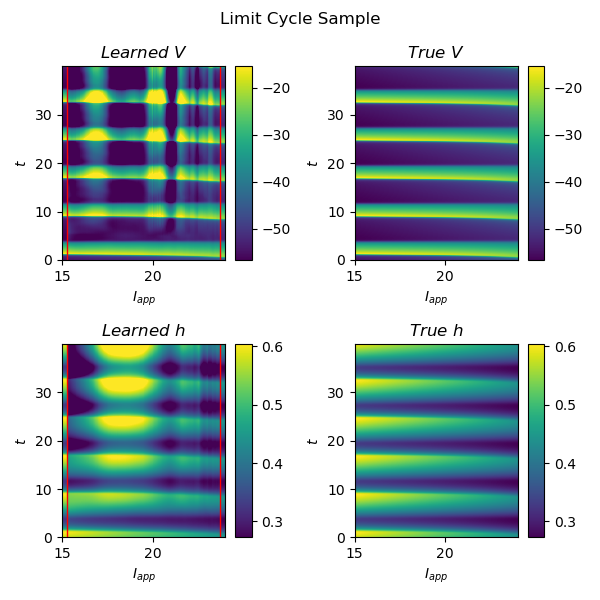

In [58]:
# Plot short integration trajectories for the limit cycle training data and compare to the truth.
for (learned_data, true_data, label) in [(Euler_learned, limit_cycle_integration_output_truth, 'Limit Cycle Sample')]:
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6, 6))

    min_V = true_data.y[:config['DATA']['domain size'], :].T.min()
    max_V = true_data.y[:config['DATA']['domain size'], :].T.max()
    min_h = true_data.y[config['DATA']['domain size']:, :].T.min()
    max_h = true_data.y[config['DATA']['domain size']:, :].T.max()
    
    fig.suptitle(label)

    ax1 = ax[0, 0].imshow(learned_data.y[:config['DATA']['domain size'], :].T, extent=[config['DATA']['domain'][0], config['DATA']['domain'][-1], t_out[0], t_out[-1]], vmin=min_V, vmax=max_V, aspect='auto', origin='lower')
    ax[0, 0].set_title('$Learned$ $V$')
    ax[0, 0].set_xlabel('$I_{app}$')
    ax[0, 0].set_ylabel('$t$')
    div1 = make_axes_locatable(ax[0, 0])
    cax1 = div1.append_axes('right', size='10%', pad=0.1)
    fig.colorbar(ax1, cax=cax1)

    ax2 = ax[0, 1].imshow(true_data.y[:config['DATA']['domain size'], :].T, extent=[config['DATA']['domain'][0], config['DATA']['domain'][-1], t_out[0], t_out[-1]], vmin=min_V, vmax=max_V, aspect='auto', origin='lower')
    ax[0, 1].set_title('$True$ $V$')
    ax[0, 1].set_xlabel('$I_{app}$')
    ax[0, 1].set_ylabel('$t$')
    div2 = make_axes_locatable(ax[0, 1])
    cax2 = div2.append_axes('right', size='10%', pad=0.1)
    fig.colorbar(ax2, cax=cax2)

    ax3 = ax[1, 0].imshow(learned_data.y[config['DATA']['domain size']:, :].T, extent=[config['DATA']['domain'][0], config['DATA']['domain'][-1], t_out[0], t_out[-1]], vmin=min_h, vmax=max_h, aspect='auto', origin='lower')
    ax[1, 0].set_title('$Learned$ $h$')
    ax[1, 0].set_xlabel('$I_{app}$')
    ax[1, 0].set_ylabel('$t$')
    div3 = make_axes_locatable(ax[1, 0])
    cax3 = div3.append_axes('right', size='10%', pad=0.1)
    fig.colorbar(ax3, cax=cax3)

    ax4 = ax[1, 1].imshow(true_data.y[config['DATA']['domain size']:, :].T, extent=[config['DATA']['domain'][0], config['DATA']['domain'][-1], t_out[0], t_out[-1]], vmin=min_h, vmax=max_h, aspect='auto', origin='lower')
    ax[1, 1].set_title('$True$ $h$')
    ax[1, 1].set_xlabel('$I_{app}$')
    ax[1, 1].set_ylabel('$t$')
    div4 = make_axes_locatable(ax[1, 1])
    cax4 = div4.append_axes('right', size='10%', pad=0.1)
    fig.colorbar(ax4, cax=cax4)

    for i in range(2):
        ax[i, 0].axvline(config['DATA']['domain'][config['MODEL']['boundary index']], color='red', linewidth=1)
        ax[i, 0].axvline(config['DATA']['domain'][-config['MODEL']['boundary index']-1], color='red', linewidth=1)
    
    fig.tight_layout()
    
if config['GENERAL']['figure saving']:
    fig.savefig(os.path.join(config['GENERAL']['figure path'], 'PDE_spacetime_unfiltered.png'), dpi=300)

<IPython.core.display.Javascript object>


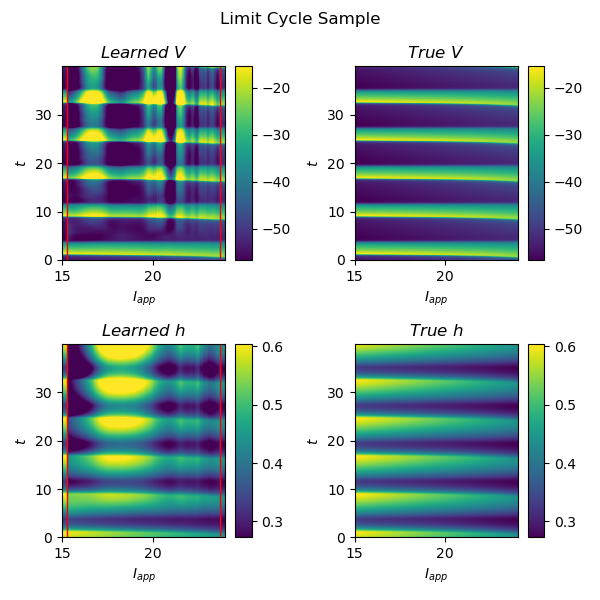

In [59]:
# Plot short integration trajectories for the limit cycle training data and compare to the truth.
for (learned_data, true_data, label) in [(limit_cycle_integration_output_learned, limit_cycle_integration_output_truth, 'Limit Cycle Sample')]:
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6, 6))

    min_V = true_data.y[:config['DATA']['domain size'], :].T.min()
    max_V = true_data.y[:config['DATA']['domain size'], :].T.max()
    min_h = true_data.y[config['DATA']['domain size']:, :].T.min()
    max_h = true_data.y[config['DATA']['domain size']:, :].T.max()
    
    fig.suptitle(label)

    ax1 = ax[0, 0].imshow(learned_data.y[:config['DATA']['domain size'], :].T, extent=[config['DATA']['domain'][0], config['DATA']['domain'][-1], t_out[0], t_out[-1]], vmin=min_V, vmax=max_V, aspect='auto', origin='lower')
    ax[0, 0].set_title('$Learned$ $V$')
    ax[0, 0].set_xlabel('$I_{app}$')
    ax[0, 0].set_ylabel('$t$')
    div1 = make_axes_locatable(ax[0, 0])
    cax1 = div1.append_axes('right', size='10%', pad=0.1)
    fig.colorbar(ax1, cax=cax1)

    ax2 = ax[0, 1].imshow(true_data.y[:config['DATA']['domain size'], :].T, extent=[config['DATA']['domain'][0], config['DATA']['domain'][-1], t_out[0], t_out[-1]], vmin=min_V, vmax=max_V, aspect='auto', origin='lower')
    ax[0, 1].set_title('$True$ $V$')
    ax[0, 1].set_xlabel('$I_{app}$')
    ax[0, 1].set_ylabel('$t$')
    div2 = make_axes_locatable(ax[0, 1])
    cax2 = div2.append_axes('right', size='10%', pad=0.1)
    fig.colorbar(ax2, cax=cax2)

    ax3 = ax[1, 0].imshow(learned_data.y[config['DATA']['domain size']:, :].T, extent=[config['DATA']['domain'][0], config['DATA']['domain'][-1], t_out[0], t_out[-1]], vmin=min_h, vmax=max_h, aspect='auto', origin='lower')
    ax[1, 0].set_title('$Learned$ $h$')
    ax[1, 0].set_xlabel('$I_{app}$')
    ax[1, 0].set_ylabel('$t$')
    div3 = make_axes_locatable(ax[1, 0])
    cax3 = div3.append_axes('right', size='10%', pad=0.1)
    fig.colorbar(ax3, cax=cax3)

    ax4 = ax[1, 1].imshow(true_data.y[config['DATA']['domain size']:, :].T, extent=[config['DATA']['domain'][0], config['DATA']['domain'][-1], t_out[0], t_out[-1]], vmin=min_h, vmax=max_h, aspect='auto', origin='lower')
    ax[1, 1].set_title('$True$ $h$')
    ax[1, 1].set_xlabel('$I_{app}$')
    ax[1, 1].set_ylabel('$t$')
    div4 = make_axes_locatable(ax[1, 1])
    cax4 = div4.append_axes('right', size='10%', pad=0.1)
    fig.colorbar(ax4, cax=cax4)

    for i in range(2):
        ax[i, 0].axvline(config['DATA']['domain'][config['MODEL']['boundary index']], color='red', linewidth=1)
        ax[i, 0].axvline(config['DATA']['domain'][-config['MODEL']['boundary index']-1], color='red', linewidth=1)
    
    fig.tight_layout()
    
if config['GENERAL']['figure saving']:
    fig.savefig(os.path.join(config['GENERAL']['figure path'], 'PDE_spacetime_unfiltered.png'), dpi=300)

<IPython.core.display.Javascript object>


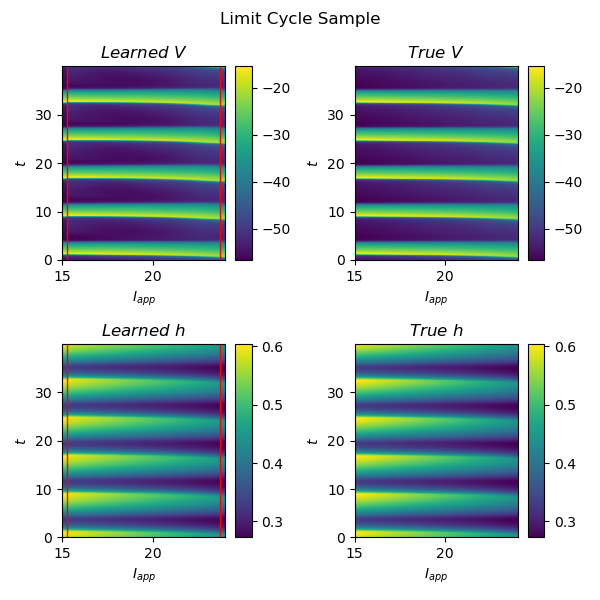

In [60]:
# Plot short integration trajectories for the limit cycle filtered training data and compare to the filtered truth.
for (learned_data, true_data, label) in [(Euler_learned, limit_cycle_integration_output_truth, 'Limit Cycle Sample')]:

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6, 6))
    
    filtered_learned_data = np.copy(true_data.y)
    filtered_true_data = np.copy(true_data.y)
    
    # Replace the interior of the learned data with the filtered versions of the learned data.
    filtered_learned_data[:config['DATA']['domain size'], :][config['MODEL']['boundary index']:-config['MODEL']['boundary index']] = pca_filter(learned_data.y.T, pca, normalizer, config['DATA']['number of retained pca coordinates']).T[:config['DATA']['domain size'], :][config['MODEL']['boundary index']:-config['MODEL']['boundary index'], :]
    filtered_learned_data[config['DATA']['domain size']:, :][config['MODEL']['boundary index']:-config['MODEL']['boundary index']] = pca_filter(learned_data.y.T, pca, normalizer, config['DATA']['number of retained pca coordinates']).T[config['DATA']['domain size']:, :][config['MODEL']['boundary index']:-config['MODEL']['boundary index'], :]
    
    # Replace the interior of the true data with the filtered versions of the true data.
    filtered_true_data[:config['DATA']['domain size'], :][config['MODEL']['boundary index']:-config['MODEL']['boundary index']] = pca_filter(true_data.y.T, pca, normalizer, config['DATA']['number of retained pca coordinates']).T[:config['DATA']['domain size'], :][config['MODEL']['boundary index']:-config['MODEL']['boundary index'], :]
    filtered_true_data[config['DATA']['domain size']:, :][config['MODEL']['boundary index']:-config['MODEL']['boundary index']] = pca_filter(true_data.y.T, pca, normalizer, config['DATA']['number of retained pca coordinates']).T[config['DATA']['domain size']:, :][config['MODEL']['boundary index']:-config['MODEL']['boundary index'], :]
    
    min_V = filtered_true_data[:config['DATA']['domain size'], :].min()
    max_V = filtered_true_data[:config['DATA']['domain size'], :].max()
    min_h = filtered_true_data[config['DATA']['domain size']:, :].min()
    max_h = filtered_true_data[config['DATA']['domain size']:, :].max()
    
    fig.suptitle(label)

    ax1 = ax[0, 0].imshow(filtered_learned_data[:config['DATA']['domain size'], :].T, extent=[config['DATA']['domain'][0], config['DATA']['domain'][-1], t_out[0], t_out[-1]], vmin=min_V, vmax=max_V, aspect='auto', origin='lower')
    ax[0, 0].set_title('$Learned$ $V$')
    ax[0, 0].set_xlabel('$I_{app}$')
    ax[0, 0].set_ylabel('$t$')
    div1 = make_axes_locatable(ax[0, 0])
    cax1 = div1.append_axes('right', size='10%', pad=0.1)
    fig.colorbar(ax1, cax=cax1)
    
    ax2 = ax[0, 1].imshow(filtered_true_data[:config['DATA']['domain size'], :].T, extent=[config['DATA']['domain'][0], config['DATA']['domain'][-1], t_out[0], t_out[-1]], vmin=min_V, vmax=max_V, aspect='auto', origin='lower')
    ax[0, 1].set_title('$True$ $V$')
    ax[0, 1].set_xlabel('$I_{app}$')
    ax[0, 1].set_ylabel('$t$')
    div2 = make_axes_locatable(ax[0, 1])
    cax2 = div2.append_axes('right', size='10%', pad=0.1)
    fig.colorbar(ax2, cax=cax2)

    ax3 = ax[1, 0].imshow(filtered_learned_data[config['DATA']['domain size']:, :].T, extent=[config['DATA']['domain'][0], config['DATA']['domain'][-1], t_out[0], t_out[-1]], vmin=min_h, vmax=max_h, aspect='auto', origin='lower')
    ax[1, 0].set_title('$Learned$ $h$')
    ax[1, 0].set_xlabel('$I_{app}$')
    ax[1, 0].set_ylabel('$t$')
    div3 = make_axes_locatable(ax[1, 0])
    cax3 = div3.append_axes('right', size='10%', pad=0.1)
    fig.colorbar(ax3, cax=cax3)

    ax4 = ax[1, 1].imshow(filtered_true_data[config['DATA']['domain size']:, :].T, extent=[config['DATA']['domain'][0], config['DATA']['domain'][-1], t_out[0], t_out[-1]], vmin=min_h, vmax=max_h, aspect='auto', origin='lower')
    ax[1, 1].set_title('$True$ $h$')
    ax[1, 1].set_xlabel('$I_{app}$')
    ax[1, 1].set_ylabel('$t$')
    div4 = make_axes_locatable(ax[1, 1])
    cax4 = div4.append_axes('right', size='10%', pad=0.1)
    fig.colorbar(ax4, cax=cax4)

    for i in range(2):
        ax[i, 0].axvline(config['DATA']['domain'][config['MODEL']['boundary index']], color='red', linewidth=1)
        ax[i, 0].axvline(config['DATA']['domain'][-config['MODEL']['boundary index']-1], color='red', linewidth=1)
        
    fig.tight_layout();
    
if config['GENERAL']['figure saving']:
    fig.savefig(os.path.join(config['GENERAL']['figure path'], 'PDE_spacetime_filtered.png'), dpi=300)

<IPython.core.display.Javascript object>


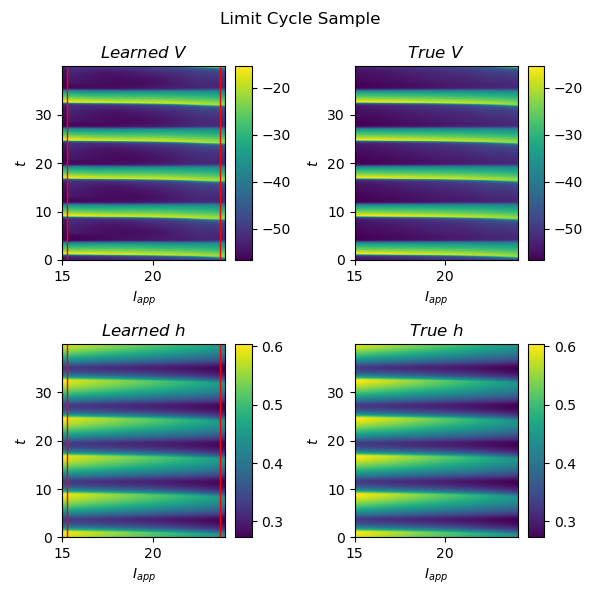

In [61]:
# Plot short integration trajectories for the limit cycle filtered training data and compare to the filtered truth.
for (learned_data, true_data, label) in [(limit_cycle_integration_output_learned, limit_cycle_integration_output_truth, 'Limit Cycle Sample')]:

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6, 6))
    
    filtered_learned_data = np.copy(true_data.y)
    filtered_true_data = np.copy(true_data.y)
    
    # Replace the interior of the learned data with the filtered versions of the learned data.
    filtered_learned_data[:config['DATA']['domain size'], :][config['MODEL']['boundary index']:-config['MODEL']['boundary index']] = pca_filter(learned_data.y.T, pca, normalizer, config['DATA']['number of retained pca coordinates']).T[:config['DATA']['domain size'], :][config['MODEL']['boundary index']:-config['MODEL']['boundary index'], :]
    filtered_learned_data[config['DATA']['domain size']:, :][config['MODEL']['boundary index']:-config['MODEL']['boundary index']] = pca_filter(learned_data.y.T, pca, normalizer, config['DATA']['number of retained pca coordinates']).T[config['DATA']['domain size']:, :][config['MODEL']['boundary index']:-config['MODEL']['boundary index'], :]
    
    # Replace the interior of the true data with the filtered versions of the true data.
    filtered_true_data[:config['DATA']['domain size'], :][config['MODEL']['boundary index']:-config['MODEL']['boundary index']] = pca_filter(true_data.y.T, pca, normalizer, config['DATA']['number of retained pca coordinates']).T[:config['DATA']['domain size'], :][config['MODEL']['boundary index']:-config['MODEL']['boundary index'], :]
    filtered_true_data[config['DATA']['domain size']:, :][config['MODEL']['boundary index']:-config['MODEL']['boundary index']] = pca_filter(true_data.y.T, pca, normalizer, config['DATA']['number of retained pca coordinates']).T[config['DATA']['domain size']:, :][config['MODEL']['boundary index']:-config['MODEL']['boundary index'], :]
    
    min_V = filtered_true_data[:config['DATA']['domain size'], :].min()
    max_V = filtered_true_data[:config['DATA']['domain size'], :].max()
    min_h = filtered_true_data[config['DATA']['domain size']:, :].min()
    max_h = filtered_true_data[config['DATA']['domain size']:, :].max()
    
    fig.suptitle(label)

    ax1 = ax[0, 0].imshow(filtered_learned_data[:config['DATA']['domain size'], :].T, extent=[config['DATA']['domain'][0], config['DATA']['domain'][-1], t_out[0], t_out[-1]], vmin=min_V, vmax=max_V, aspect='auto', origin='lower')
    ax[0, 0].set_title('$Learned$ $V$')
    ax[0, 0].set_xlabel('$I_{app}$')
    ax[0, 0].set_ylabel('$t$')
    div1 = make_axes_locatable(ax[0, 0])
    cax1 = div1.append_axes('right', size='10%', pad=0.1)
    fig.colorbar(ax1, cax=cax1)
    
    ax2 = ax[0, 1].imshow(filtered_true_data[:config['DATA']['domain size'], :].T, extent=[config['DATA']['domain'][0], config['DATA']['domain'][-1], t_out[0], t_out[-1]], vmin=min_V, vmax=max_V, aspect='auto', origin='lower')
    ax[0, 1].set_title('$True$ $V$')
    ax[0, 1].set_xlabel('$I_{app}$')
    ax[0, 1].set_ylabel('$t$')
    div2 = make_axes_locatable(ax[0, 1])
    cax2 = div2.append_axes('right', size='10%', pad=0.1)
    fig.colorbar(ax2, cax=cax2)

    ax3 = ax[1, 0].imshow(filtered_learned_data[config['DATA']['domain size']:, :].T, extent=[config['DATA']['domain'][0], config['DATA']['domain'][-1], t_out[0], t_out[-1]], vmin=min_h, vmax=max_h, aspect='auto', origin='lower')
    ax[1, 0].set_title('$Learned$ $h$')
    ax[1, 0].set_xlabel('$I_{app}$')
    ax[1, 0].set_ylabel('$t$')
    div3 = make_axes_locatable(ax[1, 0])
    cax3 = div3.append_axes('right', size='10%', pad=0.1)
    fig.colorbar(ax3, cax=cax3)

    ax4 = ax[1, 1].imshow(filtered_true_data[config['DATA']['domain size']:, :].T, extent=[config['DATA']['domain'][0], config['DATA']['domain'][-1], t_out[0], t_out[-1]], vmin=min_h, vmax=max_h, aspect='auto', origin='lower')
    ax[1, 1].set_title('$True$ $h$')
    ax[1, 1].set_xlabel('$I_{app}$')
    ax[1, 1].set_ylabel('$t$')
    div4 = make_axes_locatable(ax[1, 1])
    cax4 = div4.append_axes('right', size='10%', pad=0.1)
    fig.colorbar(ax4, cax=cax4)

    for i in range(2):
        ax[i, 0].axvline(config['DATA']['domain'][config['MODEL']['boundary index']], color='red', linewidth=1)
        ax[i, 0].axvline(config['DATA']['domain'][-config['MODEL']['boundary index']-1], color='red', linewidth=1)
        
    fig.tight_layout();
    
if config['GENERAL']['figure saving']:
    fig.savefig(os.path.join(config['GENERAL']['figure path'], 'PDE_spacetime_filtered.png'), dpi=300)

# Debugging

<IPython.core.display.Javascript object>


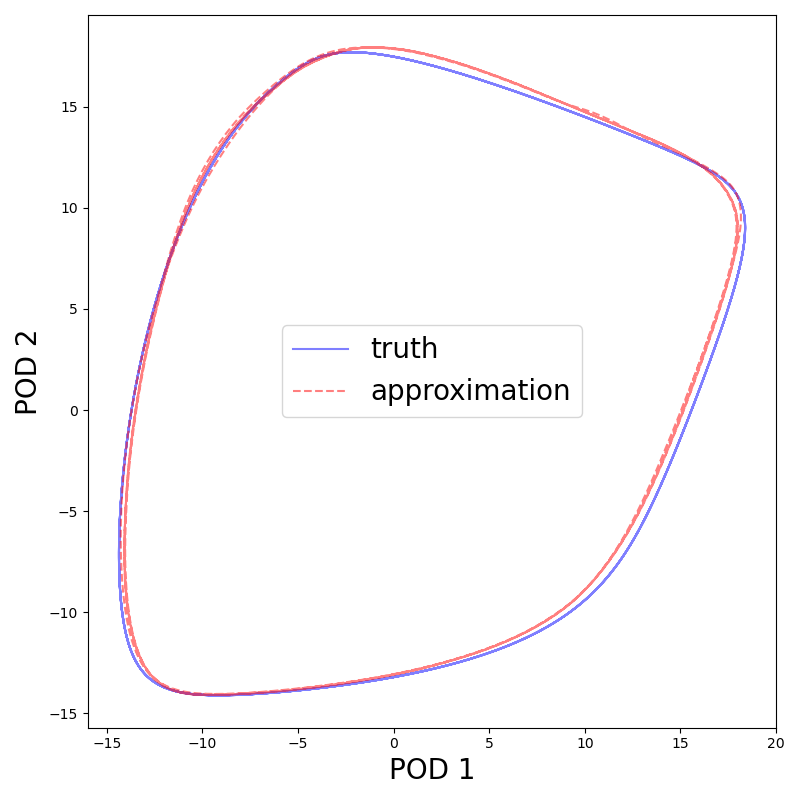

C:\Users\Thomas\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


<IPython.core.display.Javascript object>


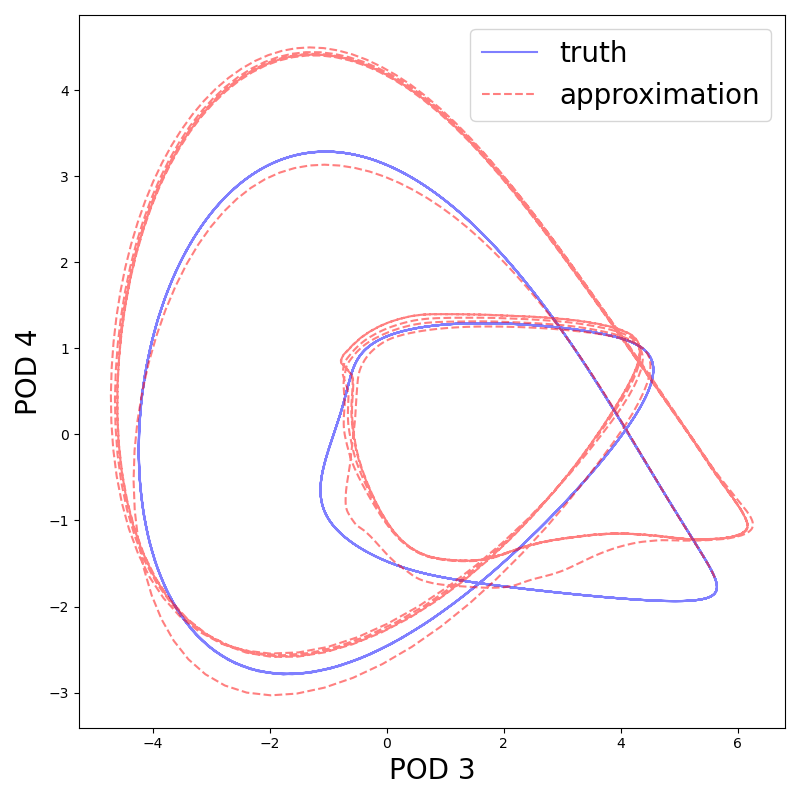

<IPython.core.display.Javascript object>


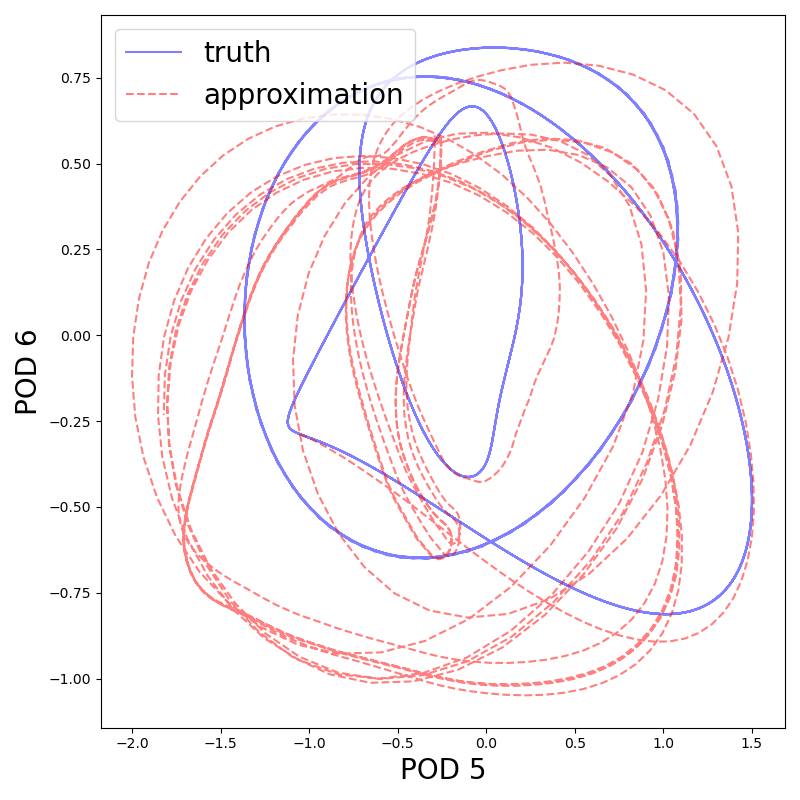

<IPython.core.display.Javascript object>


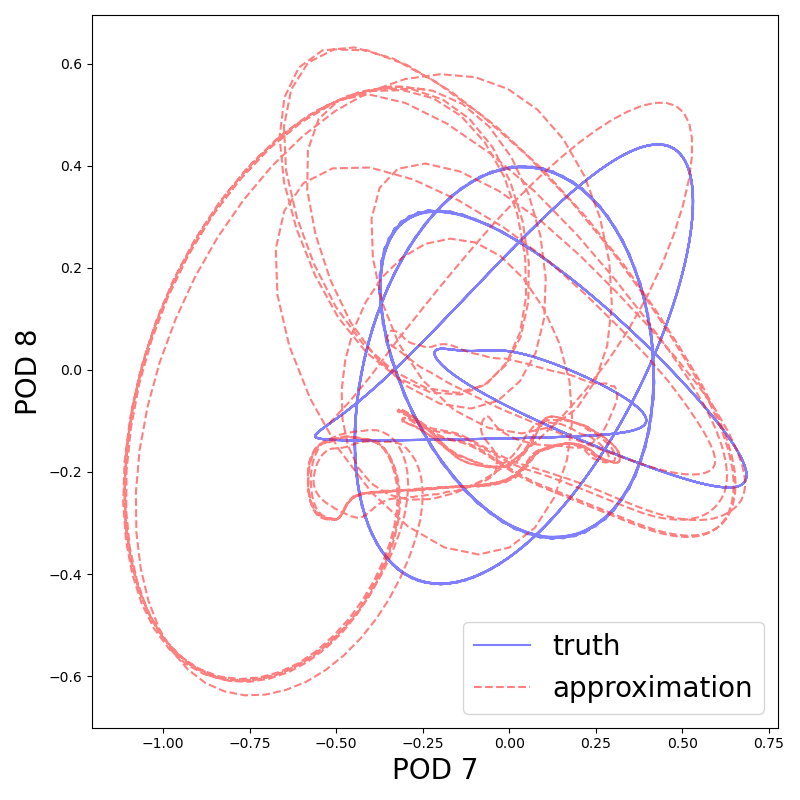

In [62]:
# Check the perturbations of each pca component.
nfigs = int(config['DATA']['number of retained pca coordinates'] / 2)
predicted_Y = pca.transform(normalizer.normalize(limit_cycle_integration_output_learned.y.T))
true_Y = pca.transform(normalizer.normalize(limit_cycle_integration_output_truth.y.T))

for i in range(nfigs):
    fig, ax = plt.subplots(figsize=(8, 8))

    ax.plot(true_Y[:, 2*i], true_Y[:, 2*i+1], c='blue', alpha=0.5, label='truth');
    ax.plot(predicted_Y[:, 2*i], predicted_Y[:, 2*i+1], linestyle='--', c='red', alpha=0.5, label='approximation');
        
    ax.legend(fontsize=20);
    ax.set_xlabel('POD {}'.format(2*i+1), fontsize=20);
    ax.set_ylabel('POD {}'.format(2*i+2), fontsize=20);

    fig.tight_layout();
    
    if config['GENERAL']['figure saving']:
        fig.savefig(os.path.join(config['GENERAL']['figure path'], 'PDE_phase_portrait_{}.png'.format(i+1)), dpi=300)

<IPython.core.display.Javascript object>


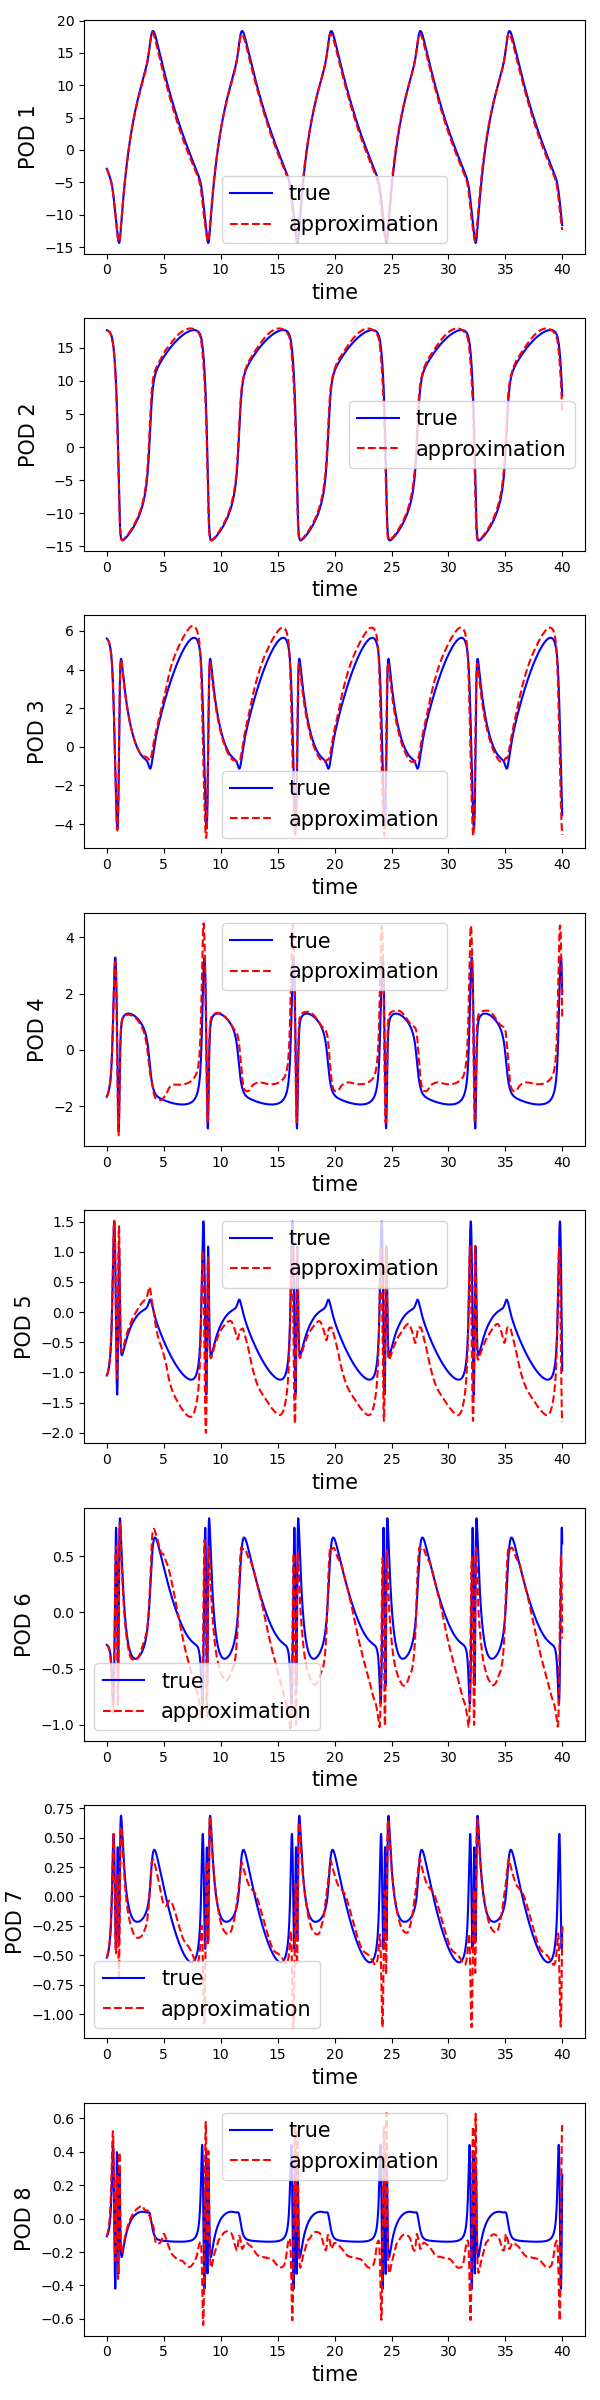

In [63]:
fig, ax = plt.subplots(nrows=config['DATA']['number of retained pca coordinates'], figsize=(6, 3*config['DATA']['number of retained pca coordinates']))
for i in range(config['DATA']['number of retained pca coordinates']):
    ax[i].plot(t_out, true_Y[:, i], c='blue', label='true');
    ax[i].plot(t_out, predicted_Y[:, i], linestyle='--', c='red', label='approximation');
    ax[i].set_xlabel('time', fontsize=15);
    ax[i].set_ylabel('POD {}'.format(i+1), fontsize=15);
    ax[i].legend(fontsize=15);
fig.tight_layout();

if config['GENERAL']['figure saving']:
    fig.savefig(os.path.join(config['GENERAL']['figure path'], 'PDE_timeseries.png'), dpi=300)

In [64]:
gc.collect()

2368

# Check the Time Derivative

In [65]:
t_outs = np.arange(0, 8, 0.01)
sim = twoConductanceEquations.TwoCondEqnSim(N=config['DATA']['domain size'],
                                            Iapp=config['DATA']['domain'],
                                            A=config['DATA']['adjacency matrix'])
sim.integrate(X0=config['DATA']['X0'].T.ravel(),
              t_span=(t_outs[0], t_outs[-1]),
              t_eval=t_outs,
              dense_output=False,
              rtol=1e-5,
              atol=1e-8
             );
X_test = np.transpose(sim.history.y.T.reshape((-1, 2, 128)), [0, 2, 1])
X_test = np.transpose(X_test, [0, 2, 1]).reshape((-1, 2*config['DATA']['domain size']))
X_test = pca_filter(X_test, pca, normalizer, config['DATA']['number of retained pca coordinates'])
X_test = np.transpose(X_test.reshape((-1, 2, config['DATA']['domain size'])), [0, 2, 1])

In [66]:
fxn_test_actual = np.stack([sim.diff(None, x.T.ravel()) for x in tqdm.tqdm_notebook(X_test)])
fxn_test_actual = fxn_test_actual.reshape(-1, 2, config['DATA']['domain size'])
fxn_test_actual = np.copy(fxn_test_actual[:, :, config['MODEL']['boundary index']:-config['MODEL']['boundary index']])
fxn_test_actual = np.transpose(fxn_test_actual, [0, 2, 1])

C:\Users\Thomas\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [67]:
fxn_test = derivative_model.predict({'u': X_test},
                                    batch_size=config['TRAINING']['batch size']
                                   )

<IPython.core.display.Javascript object>


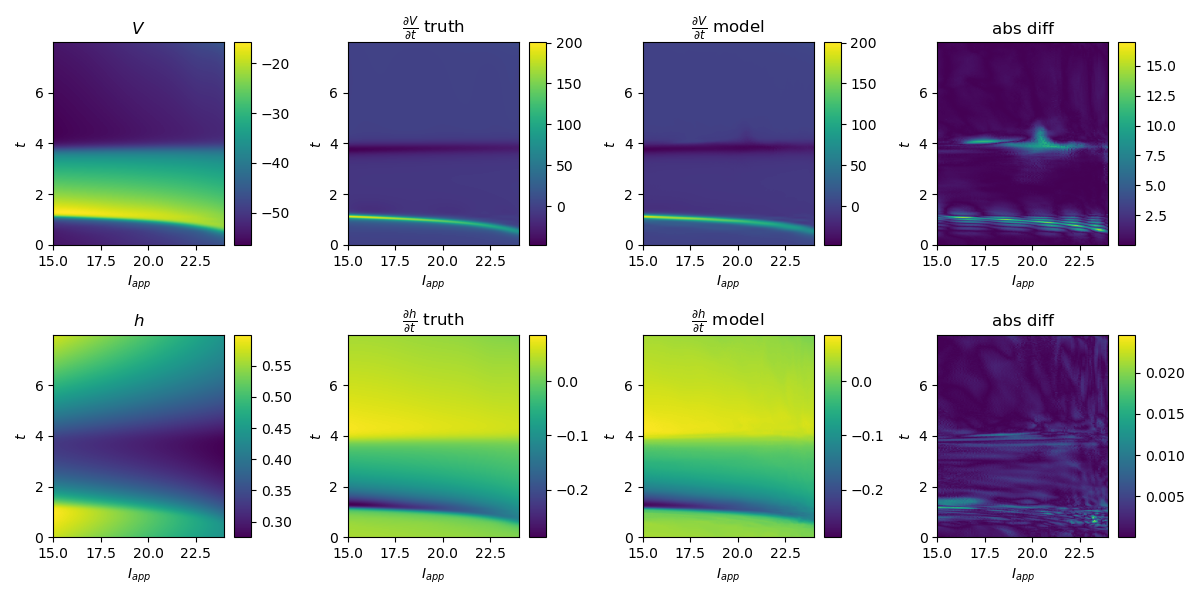

In [68]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))

V_min = np.min((fxn_test[:, :, 0], fxn_test_actual[:, :, 0]))
V_max = np.max((fxn_test[:, :, 0], fxn_test_actual[:, :, 0]))
h_min = np.min((fxn_test[:, :, 1], fxn_test_actual[:, :, 1]))
h_max = np.max((fxn_test[:, :, 1], fxn_test_actual[:, :, 1]))

ax1 = ax[0, 0].imshow(X_test[:, config['MODEL']['boundary index']:-config['MODEL']['boundary index'], 0], extent=[config['DATA']['domain'][0], config['DATA']['domain'][-1], t_outs[0], t_outs[-1]], aspect='auto', origin='lower')
div1 = make_axes_locatable(ax[0, 0])
cax1 = div1.append_axes('right', size='10%', pad=0.1)
fig.colorbar(ax1, cax=cax1)

ax2 = ax[0, 1].imshow(fxn_test_actual[:, :, 0], extent=[config['DATA']['domain'][0], config['DATA']['domain'][-1], t_outs[0], t_outs[-1]], aspect='auto', origin='lower', vmin=V_min, vmax=V_max)
div2 = make_axes_locatable(ax[0, 1])
cax2 = div2.append_axes('right', size='10%', pad=0.1)
fig.colorbar(ax2, cax=cax2)

ax3 = ax[0, 2].imshow(fxn_test[:, :, 0], extent=[config['DATA']['domain'][0], config['DATA']['domain'][-1], t_outs[0], t_outs[-1]], aspect='auto', origin='lower', vmin=V_min, vmax=V_max)
div3 = make_axes_locatable(ax[0, 2])
cax3 = div3.append_axes('right', size='10%', pad=0.1)
fig.colorbar(ax3, cax=cax3)

ax4 = ax[0, 3].imshow(np.abs(fxn_test[:, :, 0]-fxn_test_actual[:, :, 0]), extent=[config['DATA']['domain'][0], config['DATA']['domain'][-1], t_outs[0], t_outs[-1]], aspect='auto', origin='lower')
div4 = make_axes_locatable(ax[0, 3])
cax4 = div4.append_axes('right', size='10%', pad=0.1)
fig.colorbar(ax4, cax=cax4)

ax5 = ax[1, 0].imshow(X_test[:, config['MODEL']['boundary index']:-config['MODEL']['boundary index'], 1], extent=[config['DATA']['domain'][0], config['DATA']['domain'][-1], t_outs[0], t_outs[-1]], aspect='auto', origin='lower')
div5 = make_axes_locatable(ax[1, 0])
cax5 = div5.append_axes('right', size='10%', pad=0.1)
fig.colorbar(ax5, cax=cax5)

ax6 = ax[1, 1].imshow(fxn_test_actual[:, :, 1], extent=[config['DATA']['domain'][0], config['DATA']['domain'][-1], t_outs[0], t_outs[-1]], aspect='auto', origin='lower', vmin=h_min, vmax=h_max)
div6 = make_axes_locatable(ax[1, 1])
cax6 = div6.append_axes('right', size='10%', pad=0.1)
fig.colorbar(ax6, cax=cax6)

ax7 = ax[1, 2].imshow(fxn_test[:, :, 1], extent=[config['DATA']['domain'][0], config['DATA']['domain'][-1], t_outs[0], t_outs[-1]], aspect='auto', origin='lower', vmin=h_min, vmax=h_max)
div7 = make_axes_locatable(ax[1, 2])
cax7 = div7.append_axes('right', size='10%', pad=0.1)
fig.colorbar(ax7, cax=cax7)

ax8 = ax[1, 3].imshow(np.abs(fxn_test[:, :, 1]-fxn_test_actual[:, :, 1]), extent=[config['DATA']['domain'][0], config['DATA']['domain'][-1], t_outs[0], t_outs[-1]], aspect='auto', origin='lower')
div8 = make_axes_locatable(ax[1, 3])
cax8 = div8.append_axes('right', size='10%', pad=0.1)
fig.colorbar(ax8, cax=cax8)

ax[0, 0].set_xlabel('$I_{app}$');
ax[0, 0].set_ylabel('$t$');
ax[0, 0].set_title('$V$');

ax[0, 1].set_xlabel('$I_{app}$');
ax[0, 1].set_ylabel('$t$');
ax[0, 1].set_title(r'$\frac{\partial V}{\partial t}$ truth');

ax[0, 2].set_xlabel('$I_{app}$');
ax[0, 2].set_ylabel('$t$');
ax[0, 2].set_title(r'$\frac{\partial V}{\partial t}$ model');

ax[0, 3].set_xlabel('$I_{app}$');
ax[0, 3].set_ylabel('$t$');
ax[0, 3].set_title('abs diff');

ax[1, 0].set_xlabel('$I_{app}$');
ax[1, 0].set_ylabel('$t$');
ax[1, 0].set_title('$h$');

ax[1, 1].set_xlabel('$I_{app}$');
ax[1, 1].set_ylabel('$t$');
ax[1, 1].set_title(r'$\frac{\partial h}{\partial t}$ truth');

ax[1, 2].set_xlabel('$I_{app}$');
ax[1, 2].set_ylabel('$t$');
ax[1, 2].set_title(r'$\frac{\partial h}{\partial t}$ model');

ax[1, 3].set_xlabel('$I_{app}$');
ax[1, 3].set_ylabel('$t$');
ax[1, 3].set_title('abs diff');

fig.tight_layout();

if config['GENERAL']['figure saving']:
    fig.savefig(os.path.join(config['GENERAL']['figure path'], 'temporal_derivatives.png'), dpi=300)

In [69]:
# fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

# movieWriter = FFMpegWriter(fps=20, codec='h264')

# ax[0, 0].set_xlabel('$I_{app}$');
# ax[0, 0].set_ylabel('$V$');

# ax[0, 1].set_xlabel('$I_{app}$');
# ax[0, 1].set_ylabel('$h$');

# ax[1, 0].set_xlabel('$I_{app}$');
# ax[1, 0].set_ylabel(r'$\frac{\partial V}{\partial t}$');

# ax[1, 1].set_xlabel('$I_{app}$');
# ax[1, 1].set_ylabel(r'$\frac{\partial h}{\partial t}$');

# fig.suptitle('time={}'.format(t_outs[0]))
# fig.tight_layout();

# with movieWriter.saving(fig, os.path.join(config['GENERAL']['figure path'], 'temporal_derivatives.mp4'), dpi=300):
#     for index in tqdm.tqdm_notebook(range(len(t_outs)), total=len(t_outs)):
#         del ax[0, 0].lines[:], ax[0, 1].lines[:], ax[1, 0].lines[:], ax[1, 1].lines[:]
#         ax[0, 0].plot(config['DATA']['domain'][config['MODEL']['boundary index']:-config['MODEL']['boundary index']], X_test[index, config['MODEL']['boundary index']:-config['MODEL']['boundary index'], 0], c='blue', label='truth');
#         ax[0, 1].plot(config['DATA']['domain'][config['MODEL']['boundary index']:-config['MODEL']['boundary index']], X_test[index, config['MODEL']['boundary index']:-config['MODEL']['boundary index'], 1], c='blue', label='truth');
#         ax[1, 0].plot(config['DATA']['domain'][config['MODEL']['boundary index']:-config['MODEL']['boundary index']], fxn_test_actual[index, :, 0], c='blue', label='truth');
#         ax[1, 0].plot(config['DATA']['domain'][config['MODEL']['boundary index']:-config['MODEL']['boundary index']], fxn_test[index, :, 0], linestyle='--', c='red', label='approximation');
#         ax[1, 1].plot(config['DATA']['domain'][config['MODEL']['boundary index']:-config['MODEL']['boundary index']], fxn_test_actual[index, :, 1], c='blue', label='truth');
#         ax[1, 1].plot(config['DATA']['domain'][config['MODEL']['boundary index']:-config['MODEL']['boundary index']], fxn_test[index, :, 1], linestyle='--', c='red', label='approximation');
        
#         ax[0, 0].relim(); ax[0, 1].relim(); ax[1, 0].relim(); ax[1, 1].relim();
        
#         ax[0, 0].legend();
#         ax[0, 1].legend();
#         ax[1, 0].legend();
#         ax[1, 1].legend();
#         fig.suptitle('time={:.2f}'.format(t_outs[index]))
#         movieWriter.grab_frame()

# Try Integrating Without a Filter

In [70]:
# # Integrate to test the learned rhs.
# dt = 0.001
# t_out = np.arange(0, 0.002, dt)
# steps = len(t_out) - 1

# boundary_condition_sim = twoConductanceEquations.TwoCondEqnSim(N=config['DATA']['domain size'], Iapp=config['DATA']['domain'])
# boundary_condition_sim.integrate(X0=config['DATA']['X0'].T.ravel(),
#                                  t_span=(t_out[0], t_out[-1]),
#                                  dense_output=True,
#                                  rtol=1e-5,
#                                  atol=1e-8
#                                 )

# f = rhs_generator(pca,
#                   normalizer,
#                   config['DATA']['number of retained pca coordinates'],
#                   config['MODEL']['boundary index'],
#                   config['DATA']['domain size'],
#                   derivative_model,
#                   boundary_condition_sim)

# class Bunch():
#     pass

# limit_cycle_integration_output_learned = Bunch()
# limit_cycle_integration_output_learned.t = np.zeros((steps+1,))
# limit_cycle_integration_output_learned.y = np.zeros((config['DATA']['X0'][config['MODEL']['boundary index']:-config['MODEL']['boundary index']].T.ravel().shape[0], steps+1))
# limit_cycle_integration_output_learned.t[0] = t_out[0]
# limit_cycle_integration_output_learned.y[:, 0] = config['DATA']['X0'][config['MODEL']['boundary index']:-config['MODEL']['boundary index']].T.ravel()
# limit_cycle_time_derivatives = []

# for i in tqdm.tqdm_notebook(range(steps)):
#     t_current = limit_cycle_integration_output_learned.t[i]
#     y_current = limit_cycle_integration_output_learned.y[:, i]
    
#     t_new = t_current + dt
#     y_new = y_current + (dt * f(t_current, y_current))
    
#     limit_cycle_time_derivatives.append(f(t_current, y_current))
    
#     limit_cycle_integration_output_learned.t[i+1] = t_new
#     limit_cycle_integration_output_learned.y[:, i+1] = y_new

# limit_cycle_integration_output_truth = solve_ivp(sim.diff,
#                                                  (t_out[0], t_out[-1]),
#                                                  config['DATA']['X0'].T.ravel(),
#                                                  method='RK45',
#                                                  t_eval=t_out,
#                                                  rtol=1e-5,
#                                                  atol=1e-8
#                                                 )

# limit_cycle_integration_output_learned.y = replace_interior_of_true_solution(limit_cycle_integration_output_learned, limit_cycle_integration_output_truth)

# # Integration output shape (#states, #time steps).

In [71]:
# U_feed = boundary_condition_sim.history.sol(unused_t).reshape((2, domain_size)).T

#         # Overwrite the interior with U, while leaving the boundaries as the true solution.
#         U_feed[boundary_index:-boundary_index, :] = U.reshape((2, domain_size-(boundary_index*2))).T

#         # Filter U_feed.
#         U_feed = pca_filter(U_feed.T.ravel()[None, :], pca, normalizer, number_of_retained_pca_coordinates)
#         U_feed = U_feed.reshape((2, domain_size)).T

#         U_boundary = boundary_condition_sim.history.sol(unused_t).reshape((2, domain_size)).T
#         U_boundary[boundary_index:-boundary_index, :] = U_feed[boundary_index:-boundary_index, :]
#         U_feed = U_boundary

In [72]:
# X0_filtered = pca_filter(config['DATA']['X0'].T.ravel()[None, :], pca, normalizer, config['DATA']['number of retained pca coordinates'])[0, :]
# X0_filtered_true_boundaries = np.copy(config['DATA']['X0'][:, 0])
# X0_filtered_true_boundaries[config['MODEL']['boundary index']:-config['MODEL']['boundary index']] = X0_filtered[:128][config['MODEL']['boundary index']:-config['MODEL']['boundary index']]
# fig, ax = plt.subplots()
# ax.plot(config['DATA']['X0'][:, 0], label='X0');
# ax.plot(X0_filtered[:128], label='X0 filtered');
# ax.plot(X0_filtered_true_boundaries, label='X0 filtered true boundaries')
# ax.legend();

In [73]:
# fig, ax = plt.subplots()
# for time_derivative in limit_cycle_time_derivatives:
#     ax.plot(time_derivative);

In [74]:
# fig, ax = plt.subplots()
# for i in range(2):
#     ax.scatter(config['DATA']['domain'], limit_cycle_integration_output_learned.y[:config['DATA']['domain size'], i], s=1);